# Satellite Imagery Semantic Segmentation
Humans in the Loop has published an open access dataset annotated for a joint project with the Mohammed Bin Rashid Space Center in Dubai, the UAE. 

Original Dataset Link: https://humansintheloop.org/resources/datasets/semantic-segmentation-dataset/

### DATA MERGING

In [8]:
import os
import shutil

base_path = 'Semantic segmentation dataset' 

# Destination folders
train_image_dir = os.path.join(base_path, 'train_images')
train_mask_dir = os.path.join(base_path, 'train_masks')

# Create destination folders if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

# Loop over Tile 1 to Tile 8
for i in range(1, 9):
    tile_folder = os.path.join(base_path, f"Tile {i}")
    images_folder = os.path.join(tile_folder, 'images')
    masks_folder = os.path.join(tile_folder, 'masks')

    # Sort files to ensure consistent numbering
    image_files = sorted(os.listdir(images_folder))
    mask_files = sorted(os.listdir(masks_folder))

    # Copy and rename images
    for idx, img_file in enumerate(image_files, 1):
        src_img = os.path.join(images_folder, img_file)
        ext = os.path.splitext(img_file)[-1]
        dst_img_name = f"image_t{i}_{idx:03d}{ext}"
        dst_img = os.path.join(train_image_dir, dst_img_name)
        shutil.copy(src_img, dst_img)

    # Copy and rename masks
    for idx, mask_file in enumerate(mask_files, 1):
        src_mask = os.path.join(masks_folder, mask_file)
        ext = os.path.splitext(mask_file)[-1]
        dst_mask_name = f"image_t{i}_{idx:03d}{ext}"
        dst_mask = os.path.join(train_mask_dir, dst_mask_name)
        shutil.copy(src_mask, dst_mask)

print("✅ All images and masks renamed and moved successfully!")

✅ All images and masks renamed and moved successfully!


# Installing & Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

C:\Users\sanja\anaconda3\envs\tf\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data Augmentation using Albumentations Library
[Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [2]:
def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)
    
    return transform

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(10, 10), squeeze=True)
        f.set_tight_layout(h_pad=5, w_pad=5)

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12), squeeze=True)
        plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=0.01)

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

C:\Users\sanja\AppData\Local\Temp\ipykernel_31016\3969049360.py:11: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),


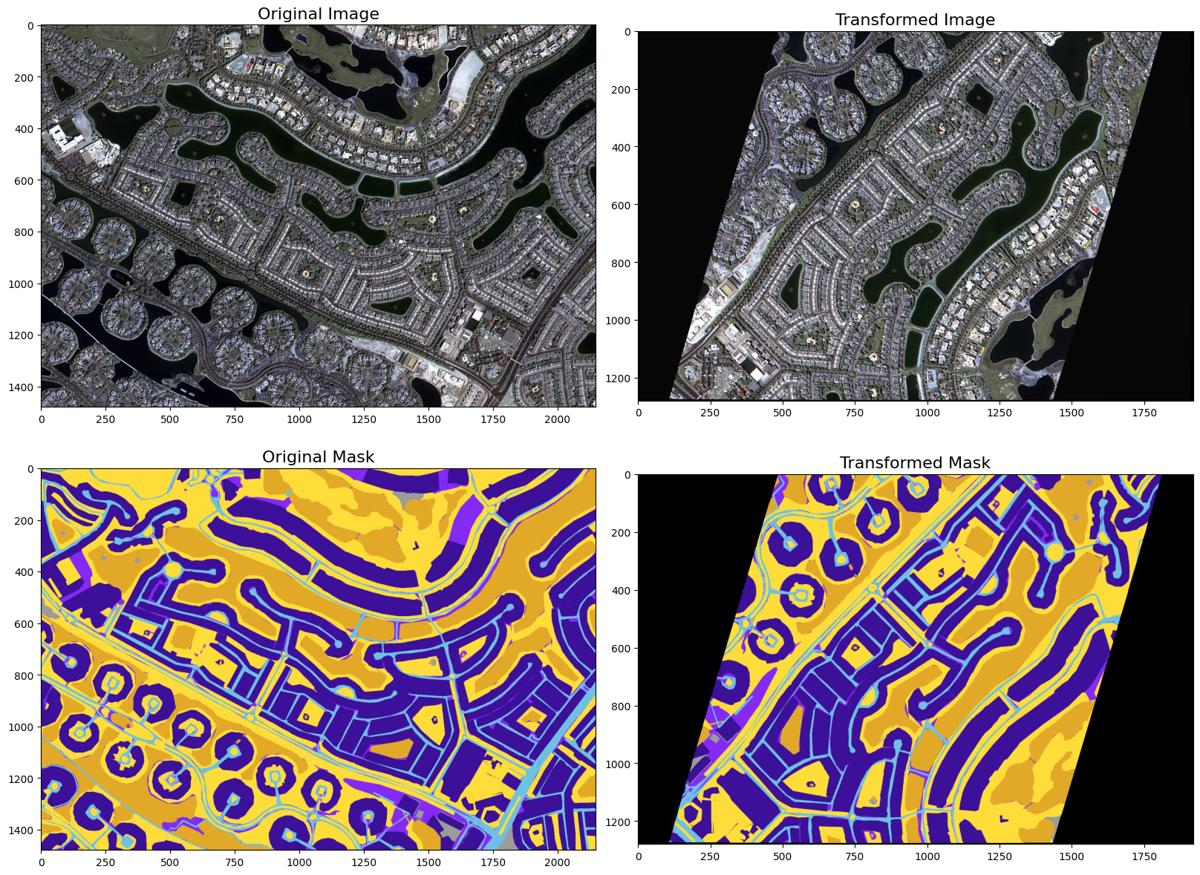

In [4]:
image = cv2.imread("Semantic segmentation dataset/train_images/image_t8_007.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread("Semantic segmentation dataset/train_masks/image_t8_007.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

transform = augment(1920, 1280)
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

cv2.imwrite('Demo Images/image.png',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('Demo Images/mask.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

visualize(transformed_image, transformed_mask, image, mask)

# Saving Augmented Images to Disk


In [5]:
# !mkdir -p "Semantic segmentation dataset/aug_images"
# !mkdir -p "Semantic segmentation dataset/aug_masks"

In [6]:
images_dir = "Semantic segmentation dataset/train_images/"
masks_dir = "Semantic segmentation dataset/train_masks/"

In [7]:
file_names = np.sort(os.listdir(images_dir)) 
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])

In [8]:
print(filenames[:10])
print(len(filenames))

['image_t1_001' 'image_t1_002' 'image_t1_003' 'image_t1_004'
 'image_t1_005' 'image_t1_006' 'image_t1_007' 'image_t1_008'
 'image_t1_009' 'image_t2_001']
72


In [9]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform_1 = augment(512, 512)
    transform_2 = augment(480, 480)
    transform_3 = augment(512, 512)
    transform_4 = augment(800, 800)
    transform_5 = augment(1024, 1024)
    transform_6 = augment(800, 800)
    transform_7 = augment(1600, 1600)
    transform_8 = augment(1920, 1280)
    
    i = 0
    for i in range(count):
        for file in filenames:
            tile = file.split('_')[1]
            img = cv2.imread(images_dir+file+'.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(masks_dir+file+'.png')
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            if tile == 't1':
                transformed = transform_1(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t2':
                transformed = transform_2(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t3':
                transformed = transform_3(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t4':
                transformed = transform_4(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t5':
                transformed = transform_5(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t6':
                transformed = transform_6(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t7':
                transformed = transform_7(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t8':
                transformed = transform_8(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
                
            cv2.imwrite('Semantic segmentation dataset/aug_images/aug_{}_'.format(str(i+1))+file+'.jpg',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
            cv2.imwrite('Semantic segmentation dataset/aug_masks/aug_{}_'.format(str(i+1))+file+'.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

In [10]:
augment_dataset(8)

C:\Users\sanja\AppData\Local\Temp\ipykernel_31016\3969049360.py:11: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),


In [11]:
# !zip -r aug_images.zip 'Semantic segmentation dataset/aug_images/'
# !zip -r aug_masks.zip 'Semantic segmentation dataset/aug_masks/'

In [12]:
# !rm -rf './aug_images/'
# !rm -rf './aug_masks/'

## Creating Validation Data

In [64]:
import os
import random
import shutil

aug_images_dir = 'Semantic segmentation dataset/aug_images'
aug_masks_dir  = 'Semantic segmentation dataset/aug_masks'

final_train_images_dir = 'Semantic segmentation dataset/final_train_images'
final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks'
final_test_images_dir  = 'Semantic segmentation dataset/final_val_images'
final_test_masks_dir   = 'Semantic segmentation dataset/final_val_masks'

# 1. Create target directories if they don’t already exist
for d in (final_train_images_dir, final_train_masks_dir, final_test_images_dir, final_test_masks_dir):
    os.makedirs(d, exist_ok=True)

# 2. List all base filenames (no extension) of your .jpg images
all_files = [
    os.path.splitext(f)[0]
    for f in os.listdir(aug_images_dir)
    if f.lower().endswith('.jpg')
]

# 3. Shuffle & split
random.seed(42)
random.shuffle(all_files)
split_idx = int(len(all_files) * 0.8)
train_files = all_files[:split_idx]
test_files  = all_files[split_idx:]

# 4. Move (or copy) the images and masks
def transfer(files, src_img_dir, src_msk_dir, dst_img_dir, dst_msk_dir, move=True):
    for name in files:
        img_src = os.path.join(src_img_dir, name + '.jpg')
        msk_src = os.path.join(src_msk_dir,  name + '.png')
        img_dst = os.path.join(dst_img_dir, name + '.jpg')
        msk_dst = os.path.join(dst_msk_dir,  name + '.png')
        if move:
            shutil.move(img_src, img_dst)
            shutil.move(msk_src, msk_dst)
        else:
            shutil.copy2(img_src, img_dst)
            shutil.copy2(msk_src, msk_dst)

# Move into train/ and test/ folders
transfer(train_files, aug_images_dir, aug_masks_dir, final_train_images_dir, final_train_masks_dir, move=True)
transfer(test_files,  aug_images_dir, aug_masks_dir, final_test_images_dir,  final_test_masks_dir,  move=True)

print(f"✅ Train: {len(train_files)} samples")
print(f"✅ Test : {len(test_files)} samples")

✅ Train: 460 samples
✅ Test : 116 samples


In [103]:
import os
import shutil

final_train_images_dir = 'Semantic segmentation dataset/final_train_images/'
final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks/'
final_val_images_dir  = 'Semantic segmentation dataset/final_val_images/'
final_val_masks_dir   = 'Semantic segmentation dataset/final_val_masks/'

# Create a list of (folder_path, subfolder_name) you want to fix
folders = [
    (final_train_images_dir, 'images'),
    (final_train_masks_dir, 'masks'),
    (final_val_images_dir, 'images'),
    (final_val_masks_dir, 'masks')
]

for folder_path, subfolder_name in folders:
    # Create the subfolder if not exists
    subfolder_path = os.path.join(folder_path, subfolder_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # Move all files into the subfolder
    for file_name in os.listdir(folder_path):
        full_file_path = os.path.join(folder_path, file_name)

        if os.path.isfile(full_file_path):
            shutil.move(full_file_path, os.path.join(subfolder_path, file_name))

print("✅ Done! All files moved correctly into subfolders.")

✅ Done! All files moved correctly into subfolders.


# Working with Augmented Dataset

In [2]:
train_images = "Semantic segmentation dataset/train_images/"
train_masks = "Semantic segmentation dataset/train_masks/" 
val_images = "Semantic segmentation dataset/val_images/"
val_masks = "Semantic segmentation dataset/val_masks/"

In [14]:
# file_names = np.sort(os.listdir(train_images + 'train/')) 
# print(file_names)
# file_names = np.char.split(file_names, '.')
# filenames = np.array([])
# for i in range(len(file_names)):
#     filenames = np.append(filenames, file_names[i][0])

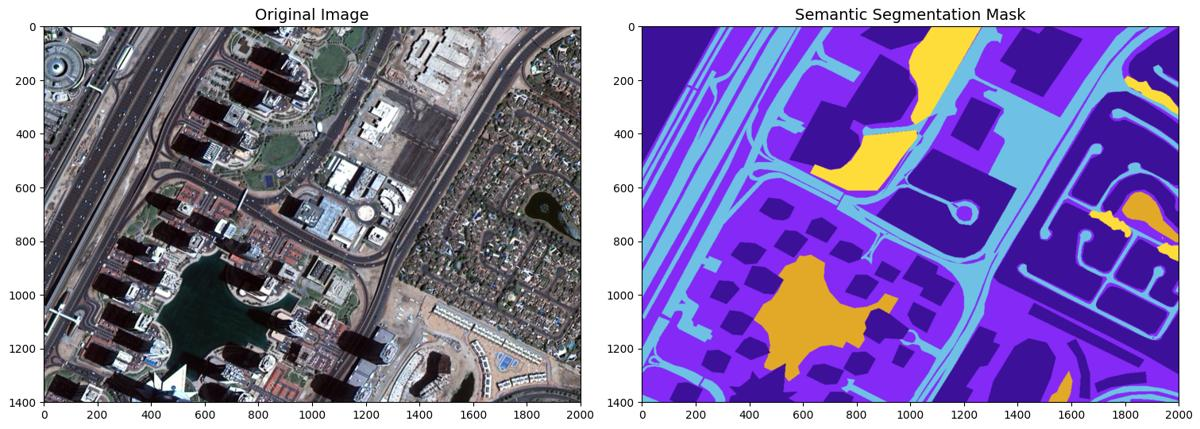

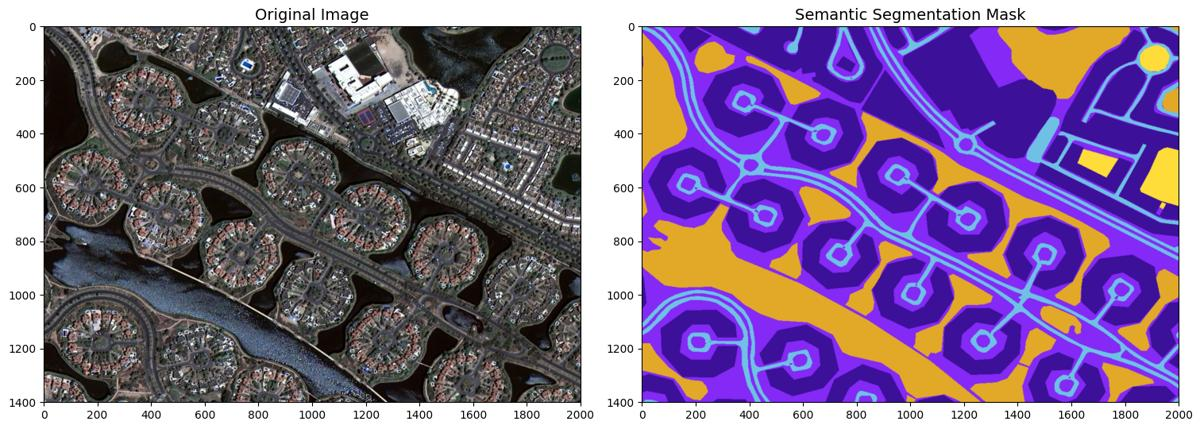

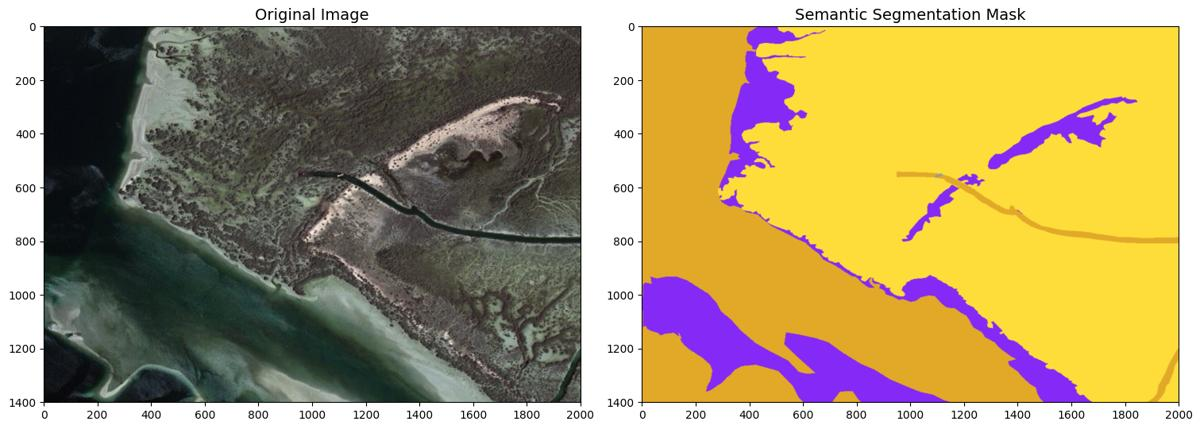

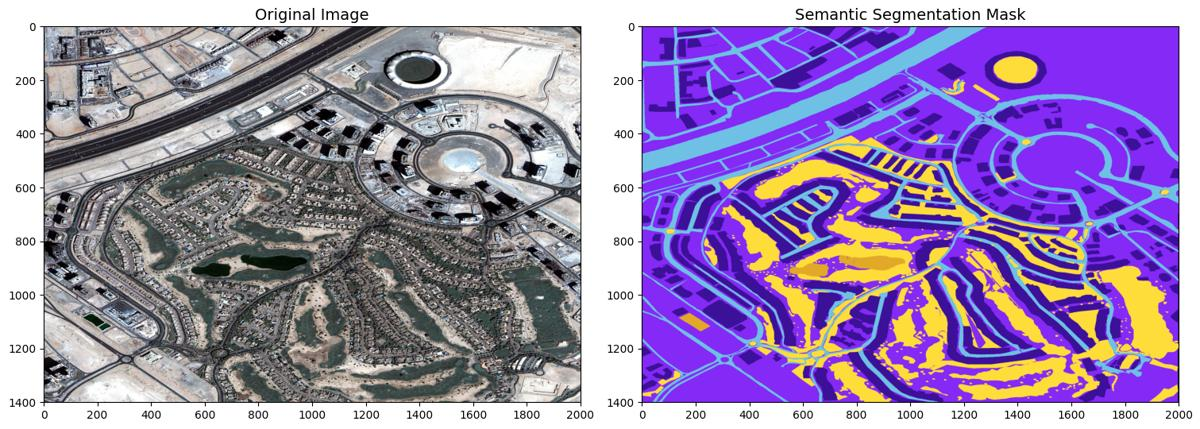

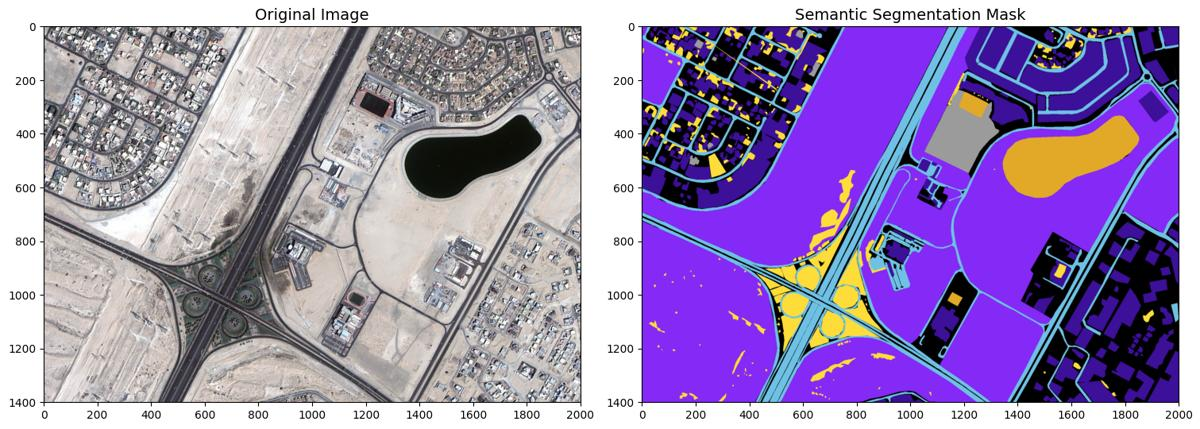

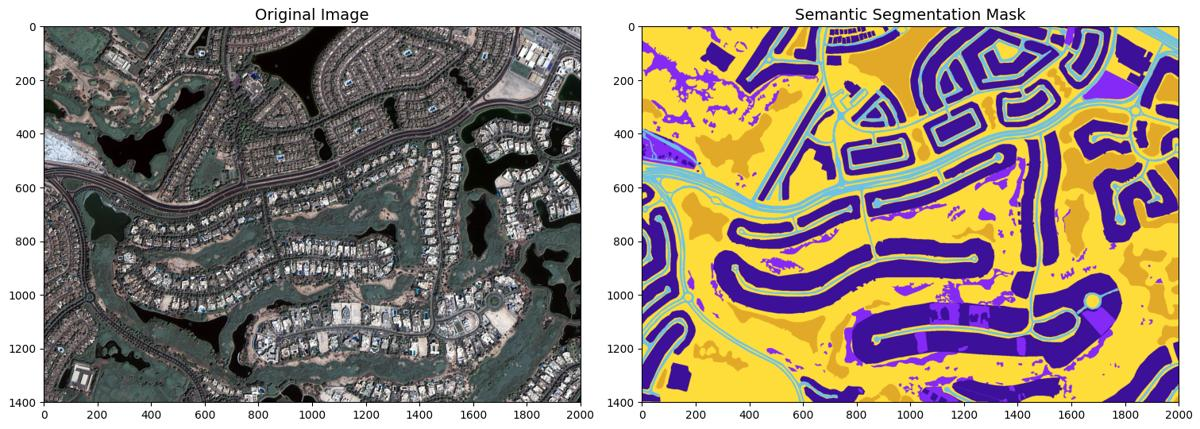

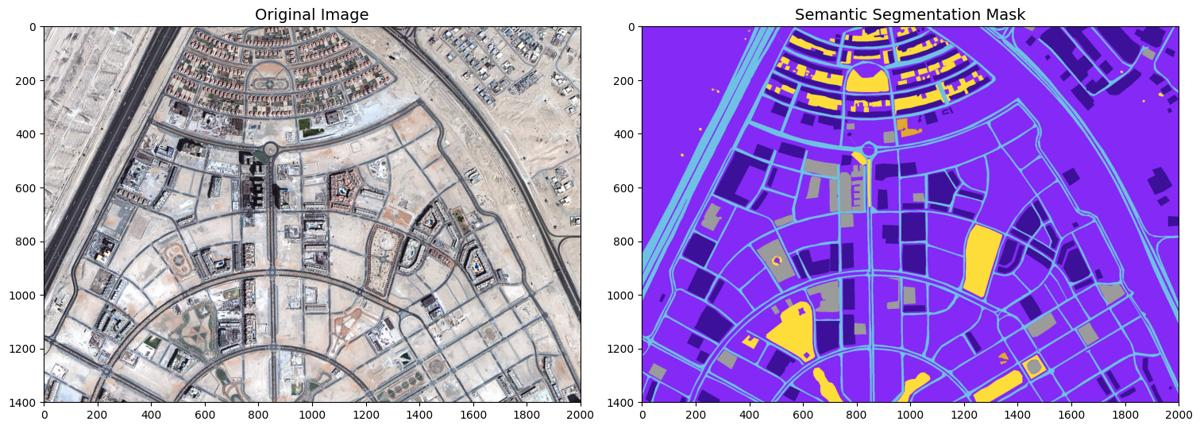

In [15]:
def show_data(files, original_images_dir, label_images_dir):

    for file in files:
        fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
        
        axs[0].imshow(cv2.resize(cv2.imread(original_images_dir+str(file)+'.jpg'), (2000,1400)))
        axs[0].set_title('Original Image', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[0].set_xticks(np.arange(0, 2001, 200))
        axs[0].set_yticks(np.arange(0, 1401, 200))
        axs[0].grid(False)
        axs[0].axis(True)

        semantic_label_image = cv2.imread(label_images_dir+str(file)+'.png')
        semantic_label_image = cv2.cvtColor(semantic_label_image, cv2.COLOR_BGR2RGB)
        semantic_label_image = cv2.resize(semantic_label_image, (2000,1400))
        axs[1].imshow(semantic_label_image)
        axs[1].set_title('Semantic Segmentation Mask', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[1].set_xticks(np.arange(0, 2001, 200))
        axs[1].set_yticks(np.arange(0, 1401, 200))
        axs[1].grid(False)
        axs[1].axis(True)

        plt.savefig('./sample_'+file, facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)
        plt.show()

        
files = ['image_t4_001', 'image_t4_005', 'image_t6_002', 'image_t7_002', 'image_t8_003', 'image_t8_004', 'image_t8_006']    
show_data(files, train_images, train_masks)    

In [16]:
aug_images = "Semantic segmentation dataset/aug_images/"
aug_masks = "Semantic segmentation dataset/aug_masks/"
# aug_images_dir = 'Semantic segmentation dataset/aug_images'
# aug_masks_dir  = 'Semantic segmentation dataset/aug_masks'
# val_images_dir = 'Semantic segmentation dataset/val_images'
# val_masks_dir  = 'Semantic segmentation dataset/val_masks'

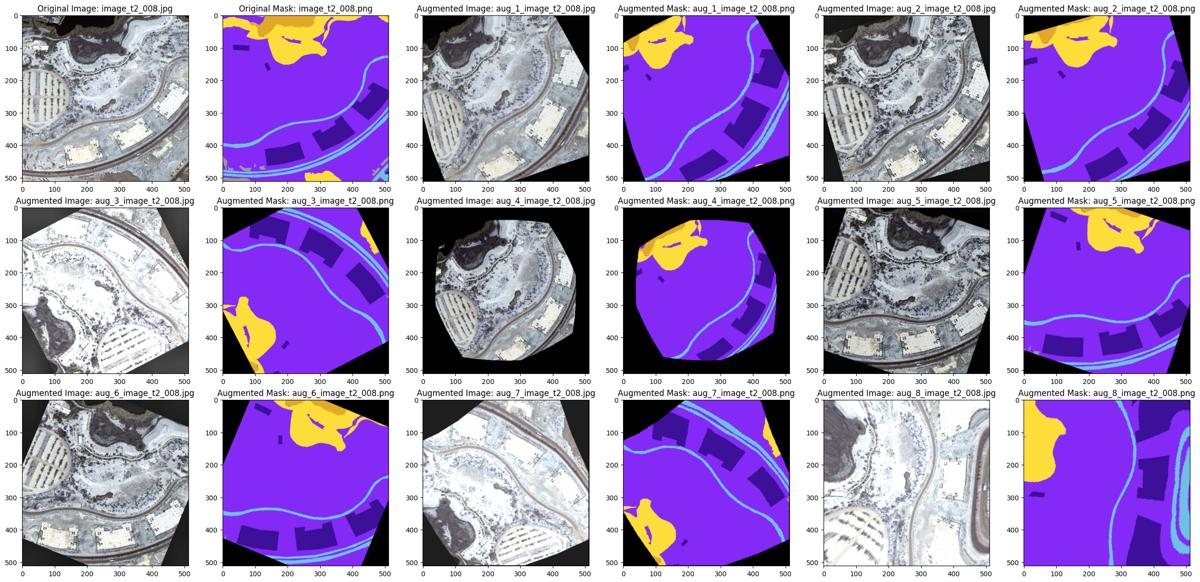

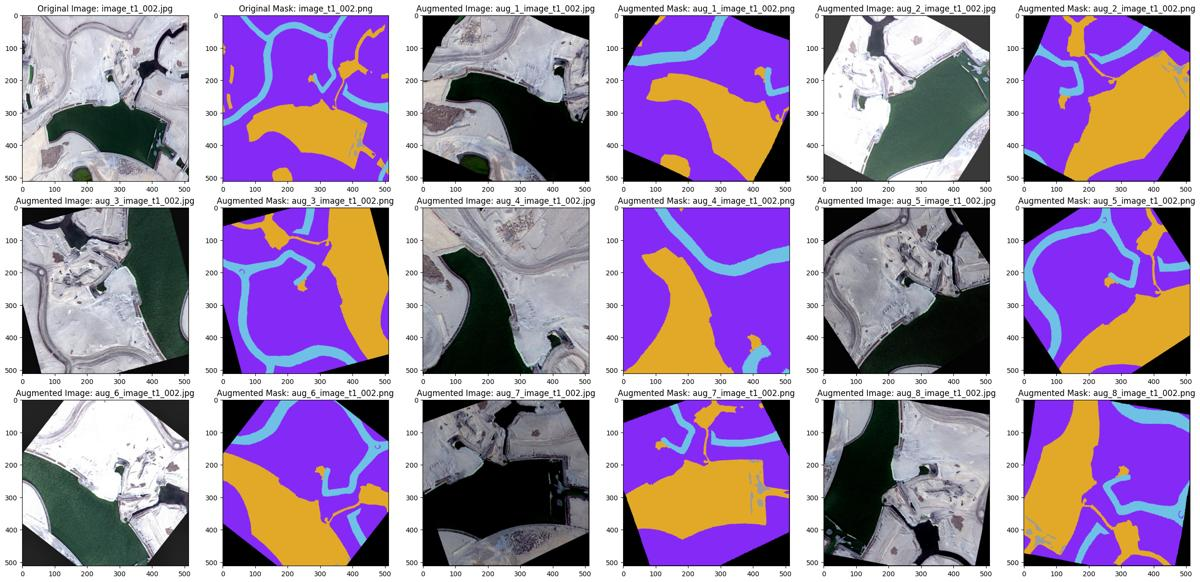

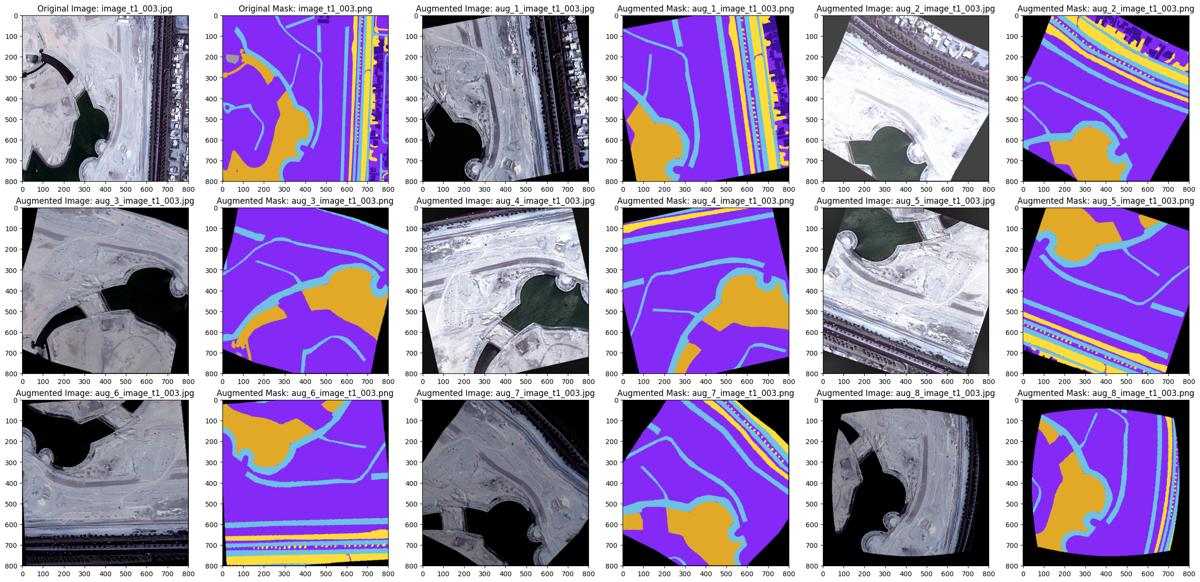

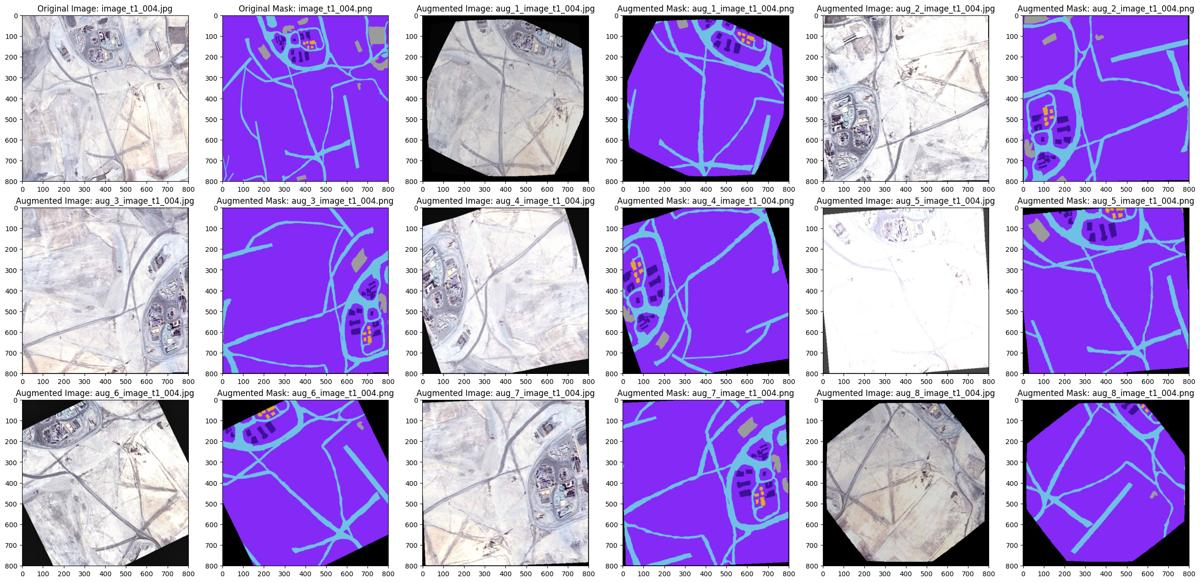

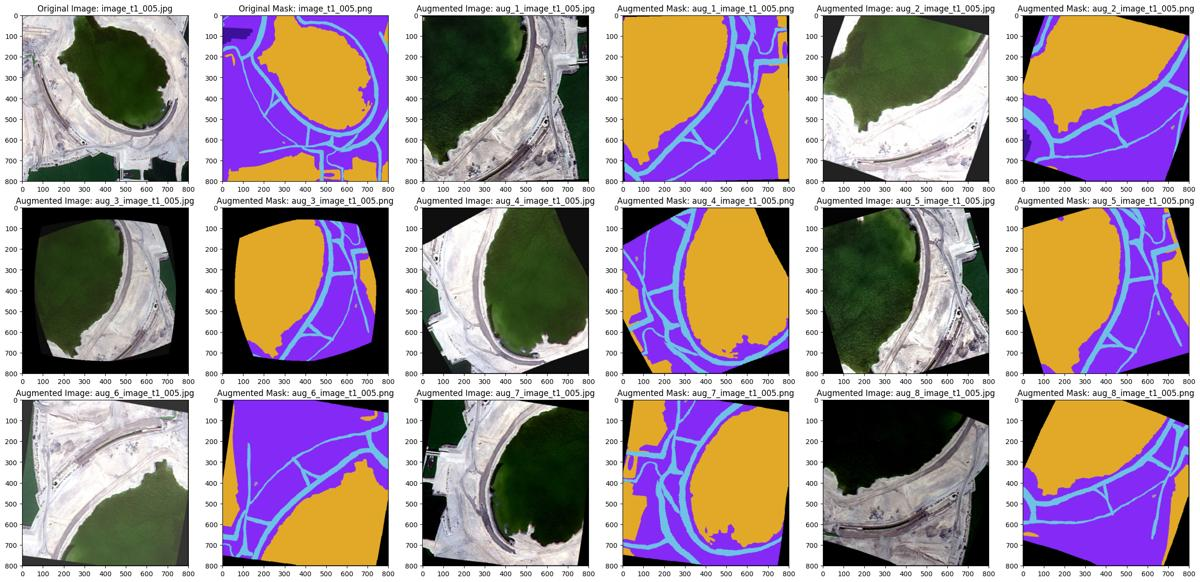

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

augmented_files = ['image_t2_008', 'image_t1_002', 'image_t1_003', 'image_t1_004', 'image_t1_005']
dims = np.array([(512, 512), (512, 512), (800, 800), (800, 800), (800, 800)])

def show_augmented_images(augmented_files, aug_images, aug_masks, train_images, train_masks):
    dim_index = 0
    for file in augmented_files:   # ✅ Corrected: 'augmented_files' not 'files'
        count_img = 1
        count_msk = 1
        fig, axs = plt.subplots(3, 6, figsize=(25, 12), constrained_layout=True)

        for i in range(3):
            for j in range(6):
                if i == 0 and j == 0:
                    # Show Original Image
                    img_path = os.path.join(train_images, file + '.jpg')
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, tuple(dims[dim_index]))
                    axs[i][j].imshow(img)
                    axs[i][j].set_title(f'Original Image: {file}.jpg', fontdict={'fontsize':12, 'fontweight':'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis('on')
                
                elif i == 0 and j == 1:
                    # Show Original Mask
                    msk_path = os.path.join(train_masks, file + '.png')
                    msk = cv2.imread(msk_path)
                    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
                    msk = cv2.resize(msk, tuple(dims[dim_index]))
                    axs[i][j].imshow(msk)
                    axs[i][j].set_title(f'Original Mask: {file}.png', fontdict={'fontsize':12, 'fontweight':'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis('on')
                
                else:
                    if j % 2 == 0:
                        # Show Augmented Image
                        aug_img_path = os.path.join(aug_images, f'aug_{count_img}_{file}.jpg')
                        aug_img = cv2.imread(aug_img_path)
                        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                        aug_img = cv2.resize(aug_img, tuple(dims[dim_index]))
                        axs[i][j].imshow(aug_img)
                        axs[i][j].set_title(f'Augmented Image: aug_{count_img}_{file}.jpg', fontdict={'fontsize':12, 'fontweight':'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis('on')
                        count_img += 1
                    else:
                        # Show Augmented Mask
                        aug_msk_path = os.path.join(aug_masks, f'aug_{count_msk}_{file}.png')
                        aug_msk = cv2.imread(aug_msk_path)
                        aug_msk = cv2.cvtColor(aug_msk, cv2.COLOR_BGR2RGB)
                        aug_msk = cv2.resize(aug_msk, tuple(dims[dim_index]))
                        axs[i][j].imshow(aug_msk)
                        axs[i][j].set_title(f'Augmented Mask: aug_{count_msk}_{file}.png', fontdict={'fontsize':12, 'fontweight':'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis('on')
                        count_msk += 1

        plt.savefig('aug_image_' + file, facecolor='w', transparent=False, bbox_inches='tight', dpi=100)
        dim_index += 1
        plt.show()

# Now call the function
show_augmented_images(augmented_files, aug_images, aug_masks, train_images, train_masks)

In [3]:
import json
with open('Semantic segmentation dataset/classes.json', 'r') as f:
    data = json.load(f) 
    print(data)
    print()
csv_rows = []
for cls in data['classes']:
    name = cls['title']
    hex_color = cls['color'].lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    csv_rows.append({'name': name, 'r': r, 'g': g, 'b': b})
class_dict_df = pd.DataFrame(csv_rows)
class_dict_df.to_csv('Semantic segmentation dataset/class_dict_df.csv', index=False)
print("CSV file created successfully!")

{'classes': [{'title': 'Water', 'shape': 'polygon', 'color': '#50E3C2', 'geometry_config': {}}, {'title': 'Land (unpaved area)', 'shape': 'polygon', 'color': '#F5A623', 'geometry_config': {}}, {'title': 'Road', 'shape': 'polygon', 'color': '#DE597F', 'geometry_config': {}}, {'title': 'Building', 'shape': 'polygon', 'color': '#D0021B', 'geometry_config': {}}, {'title': 'Vegetation', 'shape': 'polygon', 'color': '#417505', 'geometry_config': {}}, {'title': 'Unlabeled', 'shape': 'polygon', 'color': '#9B9B9B', 'geometry_config': {}}], 'tags': []}

CSV file created successfully!


In [4]:
# class_dict_df = pd.read_csv('Semantic segmentation dataset/class_dict_df.csv', index_col=False, skipinitialspace=True)
# class_dict_df

In [5]:
data = {
    'name': ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'],
    'r':    [60, 132, 110, 254, 226, 155],
    'g':    [16, 41, 193, 221, 169, 155],
    'b':    [152, 246, 228, 58, 41, 155]
}
class_dict_df_1 = pd.DataFrame(data)
class_dict_df_1.to_csv('Semantic segmentation dataset/class_dict_df_1.csv', index=False)

In [6]:
label_names= list(class_dict_df_1.name)
label_codes = []
r= np.asarray(class_dict_df_1.r)
g= np.asarray(class_dict_df_1.g)
b= np.asarray(class_dict_df_1.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(60, 16, 152),
  (132, 41, 246),
  (110, 193, 228),
  (254, 221, 58),
  (226, 169, 41),
  (155, 155, 155)],
 ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'])

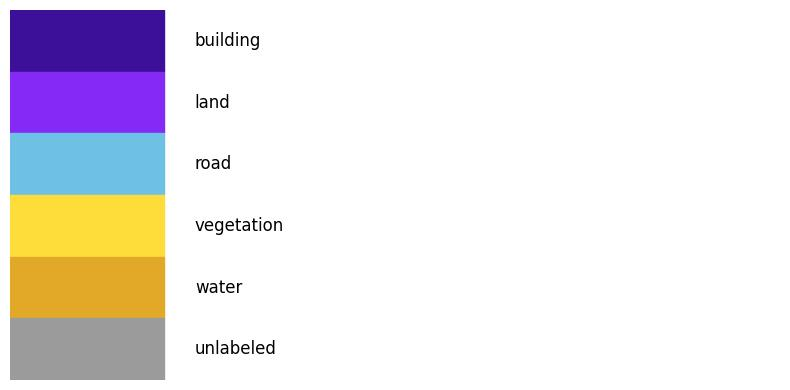


✅ Saved color legend image at: 'class_color_legend.png'


In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # Turn off axis

for idx, row in class_dict_df_1.iterrows():
    name = row['name']
    r, g, b = row['r'], row['g'], row['b']
    color = (r/255, g/255, b/255)  # Normalize for matplotlib

    # Draw color patch
    ax.add_patch(plt.Rectangle((0, idx), 1, 1, color=color))

    # Write the class name next to the patch
    ax.text(1.2, idx + 0.5, name, va='center', ha='left', fontsize=12)

ax.set_xlim(0, 5)
ax.set_ylim(0, len(class_dict_df_1))
ax.invert_yaxis()

plt.tight_layout()
save_path = 'class_color_legend.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='w')
plt.show()

print(f"\n✅ Saved color legend image at: '{save_path}'")

# Create Useful Label & Code Conversion Dictionaries

These will be used for:

* One hot encoding the mask labels for model training
* Decoding the predicted labels for interpretation and visualization

In [8]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [9]:
id2code

{0: (60, 16, 152),
 1: (132, 41, 246),
 2: (110, 193, 228),
 3: (254, 221, 58),
 4: (226, 169, 41),
 5: (155, 155, 155)}

In [10]:
id2name

{0: 'building',
 1: 'land',
 2: 'road',
 3: 'vegetation',
 4: 'water',
 5: 'unlabeled'}

# Define Functions for One Hot Encoding RGB Labels & Decoding Encoded Predictions

In [11]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating Custom Image Data Generators
## Defining Data Generators

In [37]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

# Custom Image Data Generators for Creating Batches of Frames and Masks

In [38]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        # X1i = train_image_generator.next()
        # X2i = train_mask_generator.next()
        X1i = next(train_image_generator)
        X2i = next(train_mask_generator)

        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        # X1i = val_image_generator.next()
        # X2i = val_mask_generator.next()
        X1i = next(val_image_generator)
        X2i = next(val_mask_generator)
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [39]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed=1, batch_size=8, target_size=(512, 512)):
    train_image_generator = train_frames_datagen.flow_from_directory(
        train_images_dir,
        batch_size=batch_size, 
        seed=seed, 
        target_size=target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
        train_masks_dir,
        batch_size=batch_size, 
        seed=seed, 
        target_size=target_size)

    # Wrap in iter() to make them true Python iterators
    train_image_generator = iter(train_image_generator)
    train_mask_generator = iter(train_mask_generator)

    while True:
        X1i = next(train_image_generator)
        X2i = next(train_mask_generator)

        mask_encoded = [rgb_to_onehot(X2i[0][x, :, :, :], id2code) for x in range(X2i[0].shape[0])]
        yield X1i[0], np.asarray(mask_encoded)


def ValAugmentGenerator(val_images_dir, val_masks_dir, seed=1, batch_size=8, target_size=(512, 512)):
    val_image_generator = val_frames_datagen.flow_from_directory(
        val_images_dir,
        batch_size=batch_size, 
        seed=seed, 
        target_size=target_size)

    val_mask_generator = val_masks_datagen.flow_from_directory(
        val_masks_dir,
        batch_size=batch_size, 
        seed=seed, 
        target_size=target_size)

    val_image_generator = iter(val_image_generator)
    val_mask_generator = iter(val_mask_generator)

    while True:
        X1i = next(val_image_generator)
        X2i = next(val_mask_generator)

        mask_encoded = [rgb_to_onehot(X2i[0][x, :, :, :], id2code) for x in range(X2i[0].shape[0])]
        yield X1i[0], np.asarray(mask_encoded)


In [40]:
# train_image_generator.next()	2 RGB input images	(2, 512, 512, 3)
# train_mask_generator.next()	2 RGB masks	(2, 512, 512, 3)
# rgb_to_onehot() on each	2 masks → 2 one-hot masks	(2, 512, 512, 6)
# yield	(input, one-hot masks) to model	((2, 512, 512, 3), (2, 512, 512, 6))

# Model

Categorical crossentropy is used when:
    
    1.You have multiple classes (multi-class classification).
    2.The ground truth labels are one-hot encoded.
    3.The model output is softmax (which yours is)

The Dice coefficient is a measure of overlap between:

    1.Predicted segmentation mask
    2.Ground truth mask
It's similar to Intersection over Union (IoU), but slightly different in formula.
#### Dice = (2 * |A ∩ B|) / (|A| + |B|)
Where:
- A = predicted mask
- B = ground truth mask


In [41]:
final_train_images_dir = 'Semantic segmentation dataset/final_train_images/'
final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks/'
final_val_images_dir  = 'Semantic segmentation dataset/final_val_images/'
final_val_masks_dir   = 'Semantic segmentation dataset/final_val_masks/'

In [42]:
batch_size = 16
num_train_samples = len(np.sort(os.listdir(final_train_images_dir+'/images')))
num_val_samples = len(np.sort(os.listdir(final_val_images_dir+'/images')))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  29.0
validation_steps:  29.0


## InceptionResNetV2 UNet

In [43]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    # s1 = encoder.get_layer("input_1").output           ## (512 x 512)
    s1 = encoder.get_layer("input_layer").output


    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

Encoder gradually shrinks
512 → 255 → 126 → 61 → (bridge: 30)

Zero-pad the odd ones up to
512 → 256 → 128 → 64 → (bridge padded to 32)

Decoder upsamples
32 → 64 → 128 → 256 → 512

Concatenate each upsampled map with the correspondingly padded skip feature for rich, multi-scale information at every resolution.

In [50]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 255, 255, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 255, 255, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 255, 255, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 253, 253, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 253, 253, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 253, 253, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 253, 253, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 253, 253, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 253, 253, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 126, 126, 64)      │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 126, 126, 80)      │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 126, 126, 80)      │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 126, 126, 80)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 124, 124, 192)     │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 36,793,414 (140.36 MB)

 Trainable params: 36,752,390 (140.20 MB)

 Non-trainable params: 41,024 (160.25 KB)

In [51]:
# print(tf.__version__)

In [52]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [53]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# plot_model(model, to_file='model_arch.png', show_shapes=True, show_layer_names=True, expand_nested=True)

    lr(t) = lr(0) * 0.1^^(t/s)

https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Learning-rate-scheduler.png?ssl=1

In [54]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [55]:
ValAugmentGenerator

<function __main__.ValAugmentGenerator(val_images_dir, val_masks_dir, seed=1, batch_size=8, target_size=(512, 512))>

In [56]:
# final_train_images_dir = 'Semantic segmentation dataset/final_train_images/'
# final_train_masks_dir  = 'Semantic segmentation dataset/final_train_masks/'
# final_val_images_dir  = 'Semantic segmentation dataset/final_val_images/'
# final_val_masks_dir   = 'Semantic segmentation dataset/final_val_masks/'

In [63]:
# history = model.fit(
#     TrainAugmentGenerator(train_images_dir = final_train_images_dir, train_masks_dir = final_train_masks_dir, target_size = (512, 512), batch_size = 2), 
#     steps_per_epoch=steps_per_epoch,
#     validation_data = ValAugmentGenerator(val_images_dir = final_val_images_dir, val_masks_dir = final_val_masks_dir, target_size = (512, 512), batch_size = 2), 
#     validation_steps = validation_steps, 
#     epochs = 50,
#     callbacks=callbacks,
#     use_multiprocessing=False,
#     verbose=1
# )

In [25]:
df_result = pd.DataFrame(history.history)
df_result

loss  dice_coef  accuracy  val_loss  val_dice_coef  val_accuracy  \
0   1.330114   0.253375  0.431155  1.454195       0.163692      0.354063   
1   1.078178   0.354334  0.543409  1.359554       0.194123      0.461736   
2   1.108163   0.356719  0.538060  1.308866       0.199788      0.518046   
3   0.946019   0.406603  0.614593  1.132857       0.271146      0.618099   
4   0.893717   0.419518  0.599843  0.960646       0.322100      0.720769   
5   0.907949   0.424184  0.624025  0.954913       0.356417      0.716742   
6   0.838651   0.446180  0.633356  0.827777       0.410451      0.738093   
7   0.880157   0.425858  0.601893  0.775237       0.443666      0.763800   
8   0.895723   0.441700  0.641996  0.761917       0.460482      0.705937   
9   0.840051   0.470066  0.655382  0.672405       0.514767      0.789567   
10  0.757696   0.473930  0.674923  0.633923       0.526754      0.801851   
11  0.797028   0.477535  0.655499  0.657269       0.521845      0.760750   
12  0.680273   0.498065  0.686080  0.576199       0.574438      0.814971   
13  0.775666   0.498770  0.680754  0.577309       0.588892      0.767237   
14  0.733700   0.486517  0.662202  0.575657       0.598883      0.813543   
15  0.746643   0.498454  0.684505  0.530919       0.583367      0.811794   
16  0.676955   0.513838  0.691783  0.582250       0.592383      0.804617   
17  0.675084   0.519622  0.692627  0.475221       0.635207      0.848979   
18  0.686755   0.508304  0.692633  0.521708       0.604728      0.806502   
19  0.714640   0.511582  0.697175  0.539662       0.611391      0.822287   
20  0.615545   0.561064  0.739544  0.463568       0.631061      0.842002   
21  0.654131   0.544843  0.731884  0.498239       0.620527      0.829574   
22  0.648955   0.546105  0.726060  0.458709       0.635897      0.856112   
23  0.640106   0.548693  0.726158  0.549162       0.614223      0.823963   
24  0.675130   0.547503  0.719281  0.510048       0.623744      0.819613   
25  0.586496   0.581341  0.743677  0.513690       0.610067      0.827089   
26  0.580555   0.567925  0.734885  0.542303       0.641399      0.826277   
27  0.571776   0.557153  0.725840  0.546647       0.614217      0.823502   
28  0.646099   0.540135  0.710167  0.441971       0.654174      0.855262   
29  0.560719   0.585380  0.771282  0.505790       0.614183      0.836461   
30  0.650402   0.554768  0.718318  0.423159       0.653896      0.853620   
31  0.527432   0.584452  0.755168  0.438906       0.637074      0.853951   
32  0.620855   0.565287  0.752424  0.464258       0.644401      0.838025   
33  0.564458   0.564456  0.727469  0.452306       0.637376      0.855325   
34  0.542125   0.592808  0.769201  0.419586       0.659679      0.865791   
35  0.538549   0.594950  0.764905  0.473536       0.620076      0.847837   
36  0.535420   0.600137  0.777943  0.401461       0.676685      0.867276   
37  0.528469   0.602493  0.760355  0.417242       0.649526      0.869030   
38  0.539611   0.584027  0.751607  0.420413       0.649471      0.863102   
39  0.520094   0.611621  0.782012  0.422634       0.657965      0.863618   
40  0.538887   0.599105  0.774818  0.456707       0.638154      0.851180   
41  0.515438   0.597746  0.768741  0.401802       0.665847      0.871749   
42  0.524037   0.606783  0.754139  0.424046       0.677949      0.859980   
43  0.463492   0.621873  0.778594  0.431364       0.628726      0.855075   
44  0.479188   0.618047  0.774535  0.441629       0.653548      0.850898   
45  0.484017   0.616069  0.769894  0.408069       0.657264      0.861465   
46  0.556635   0.605674  0.767528  0.438017       0.642807      0.847978   
47  0.530850   0.611650  0.774117  0.406194       0.670811      0.865143   
48  0.482798   0.611559  0.766232  0.421672       0.660325      0.855898   

          lr  
0   0.000100  
1   0.000096  
2   0.000093  
3   0.000089  
4   0.000086  
5   0.000083  
6   0.000079  
7   0.000076  
8   0.000074  
9   0.000071  
10  0.000068  
11  0.000066  
12  0.000063

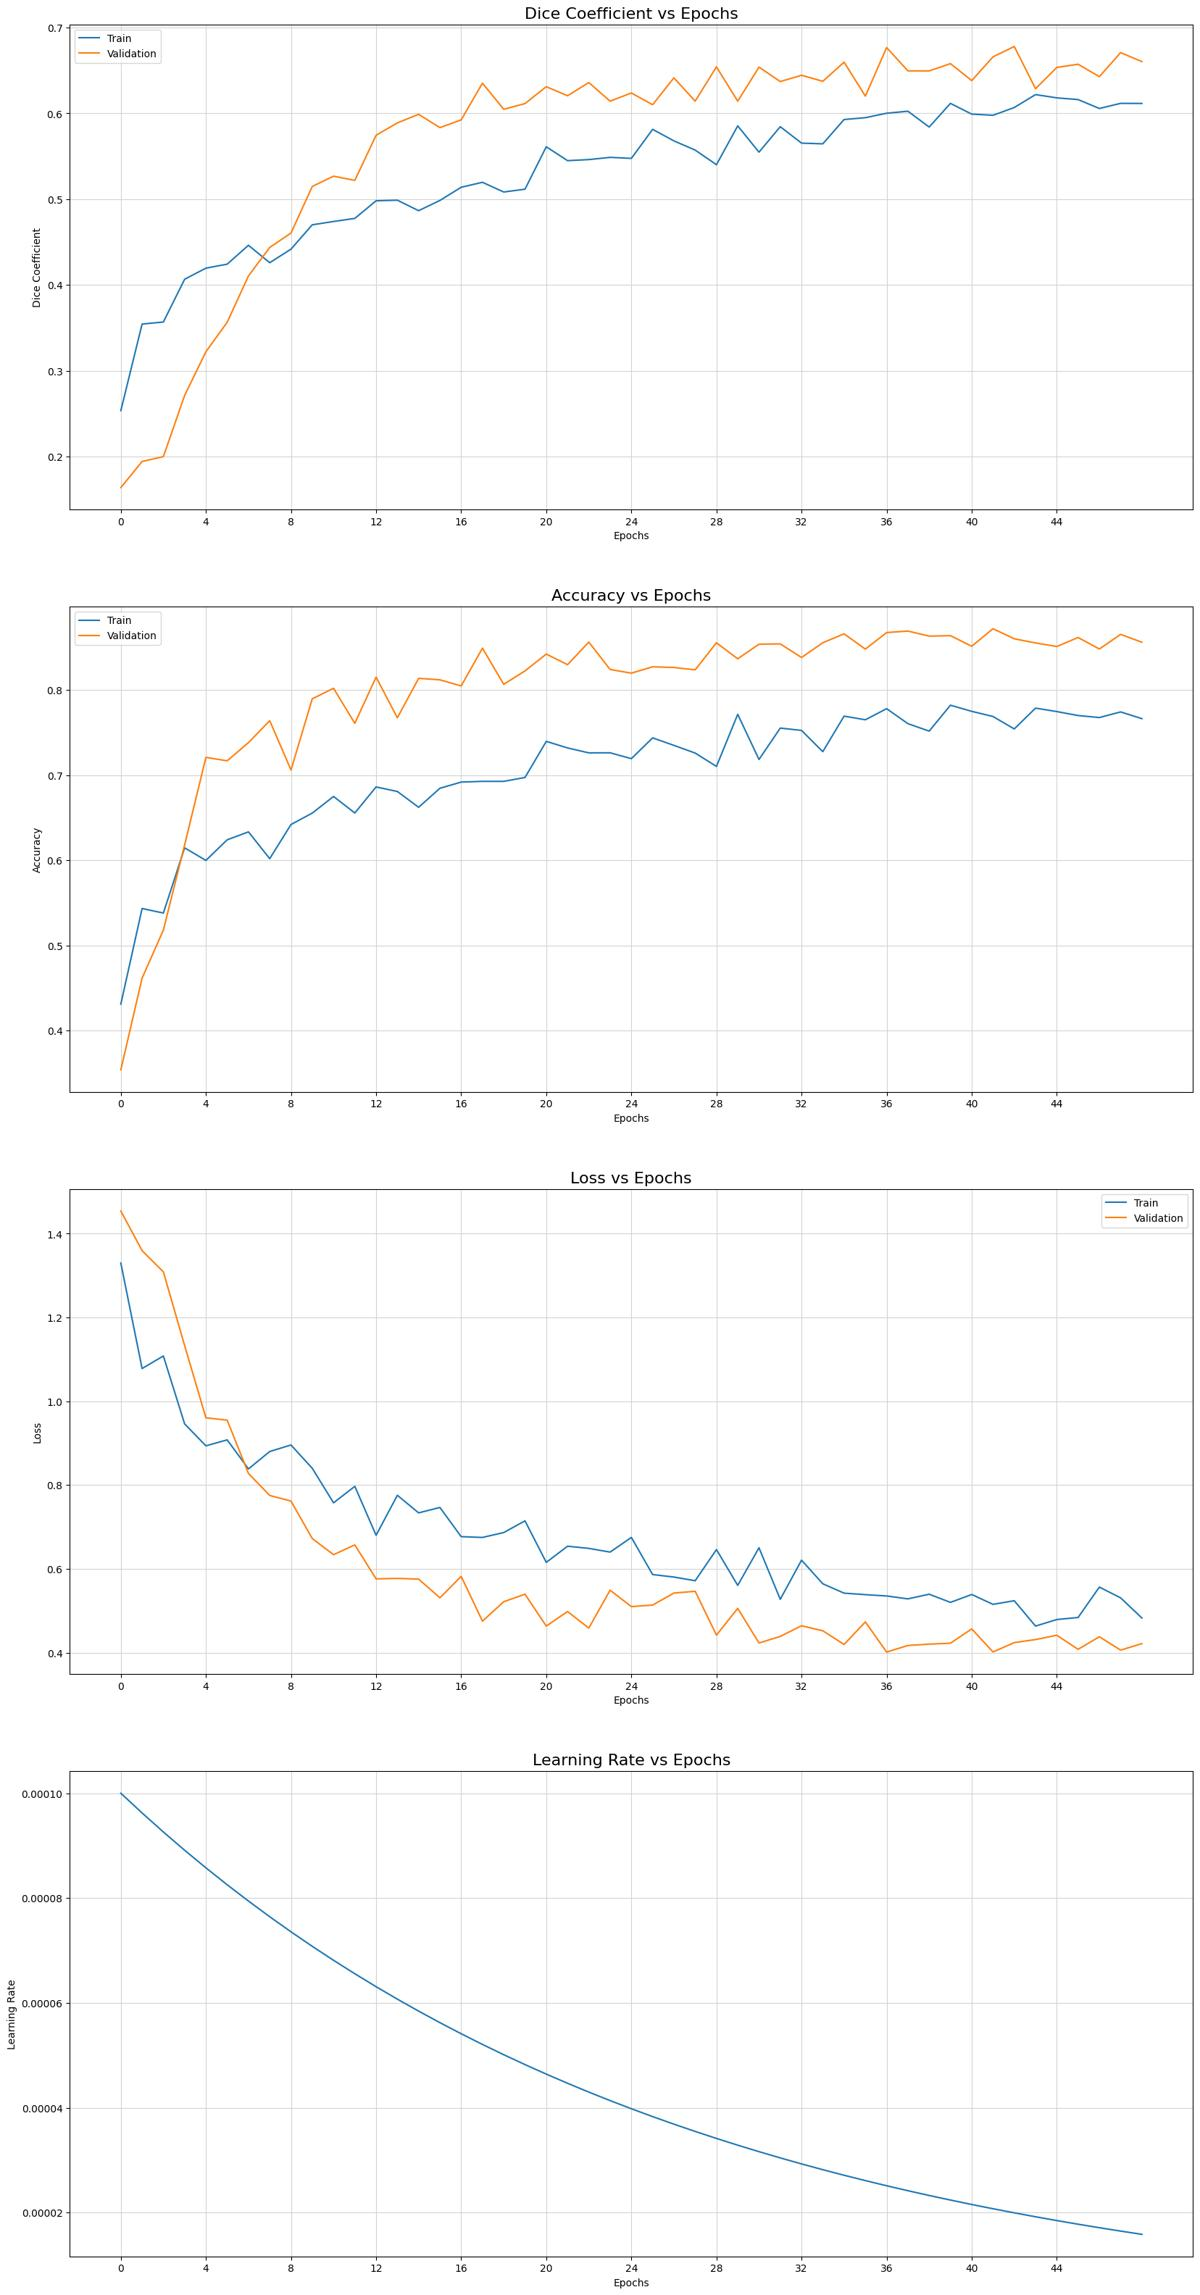

In [26]:
fig, ax = plt.subplots(4, 1, figsize=(20, 40))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

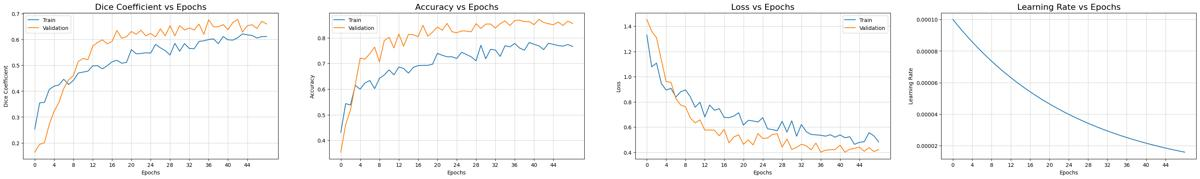

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

## MODEL LOADING AND PRECTIONS

In [58]:
model.load_weights("./InceptionResNetV2-UNet.h5")

In [59]:
testing_gen = ValAugmentGenerator(val_images_dir = final_val_images_dir, val_masks_dir = final_val_masks_dir, target_size = (512, 512))

In [60]:
# !mkdir predictions

In [61]:
# os.makedirs('./predictions', exist_ok=True)
# os.makedirs('./area_jsons', exist_ok=True)

Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


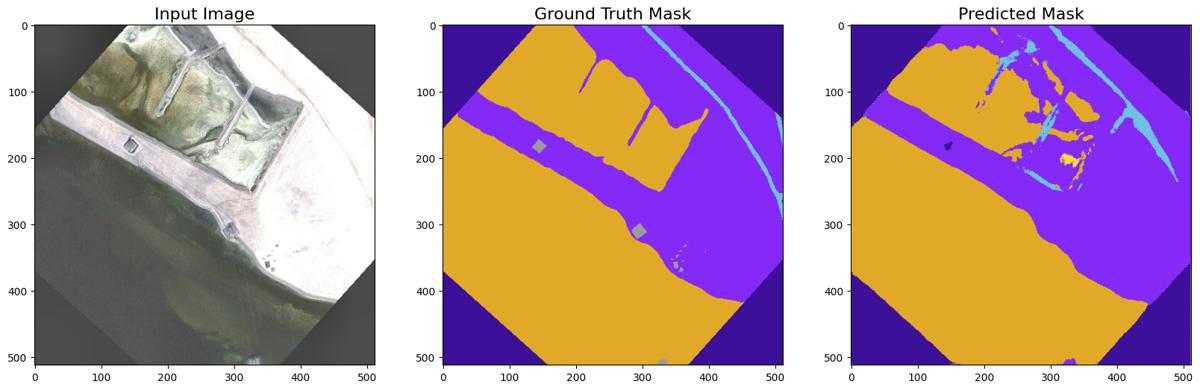


--- Statistics for Image 1 ---
  building: GT Pixels = 44785, Predicted Pixels = 43376
  land: GT Pixels = 82204, Predicted Pixels = 94046
  road: GT Pixels = 2500, Predicted Pixels = 5310
  vegetation: GT Pixels = 0, Predicted Pixels = 362
  water: GT Pixels = 131818, Predicted Pixels = 119050
  unlabeled: GT Pixels = 837, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 1:
  building: 17.08%
  land: 31.36%
  road: 0.95%
  vegetation: 0.00%
  water: 50.28%
  unlabeled: 0.32%

Area contribution (Predicted) for Image 1:
  building: 16.55%
  land: 35.88%
  road: 2.03%
  vegetation: 0.14%
  water: 45.41%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_1.json' ✅


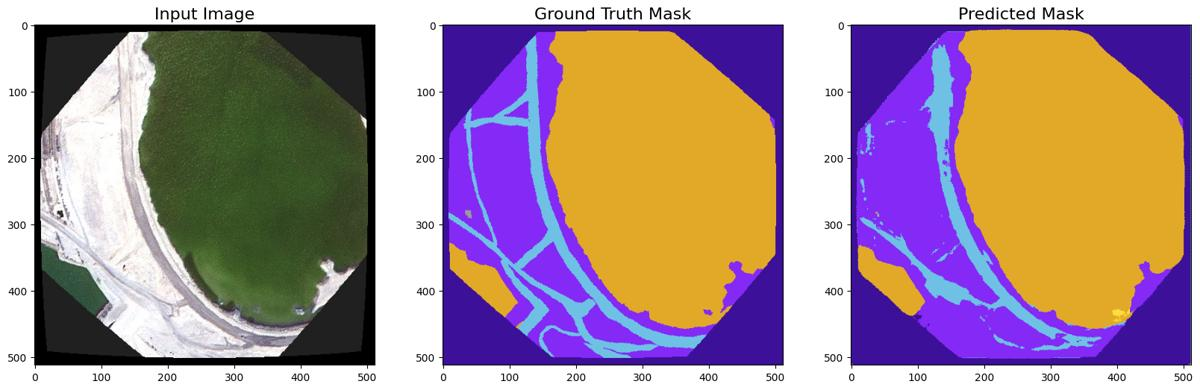


--- Statistics for Image 2 ---
  building: GT Pixels = 61675, Predicted Pixels = 59692
  land: GT Pixels = 55712, Predicted Pixels = 61263
  road: GT Pixels = 20708, Predicted Pixels = 16425
  vegetation: GT Pixels = 0, Predicted Pixels = 255
  water: GT Pixels = 123957, Predicted Pixels = 124509
  unlabeled: GT Pixels = 92, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 2:
  building: 23.53%
  land: 21.25%
  road: 7.90%
  vegetation: 0.00%
  water: 47.29%
  unlabeled: 0.04%

Area contribution (Predicted) for Image 2:
  building: 22.77%
  land: 23.37%
  road: 6.27%
  vegetation: 0.10%
  water: 47.50%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_2.json' ✅


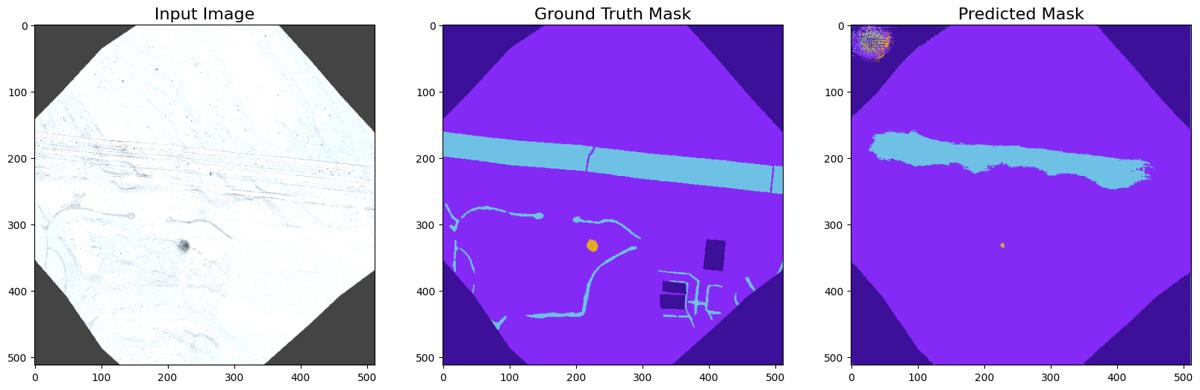


--- Statistics for Image 3 ---
  building: GT Pixels = 47000, Predicted Pixels = 40545
  land: GT Pixels = 191043, Predicted Pixels = 205191
  road: GT Pixels = 23860, Predicted Pixels = 15636
  vegetation: GT Pixels = 0, Predicted Pixels = 101
  water: GT Pixels = 241, Predicted Pixels = 378
  unlabeled: GT Pixels = 0, Predicted Pixels = 293

Area contribution (Ground Truth) for Image 3:
  building: 17.93%
  land: 72.88%
  road: 9.10%
  vegetation: 0.00%
  water: 0.09%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 3:
  building: 15.47%
  land: 78.27%
  road: 5.96%
  vegetation: 0.04%
  water: 0.14%
  unlabeled: 0.11%

Area percentages saved to './area_jsons/area_image_3.json' ✅


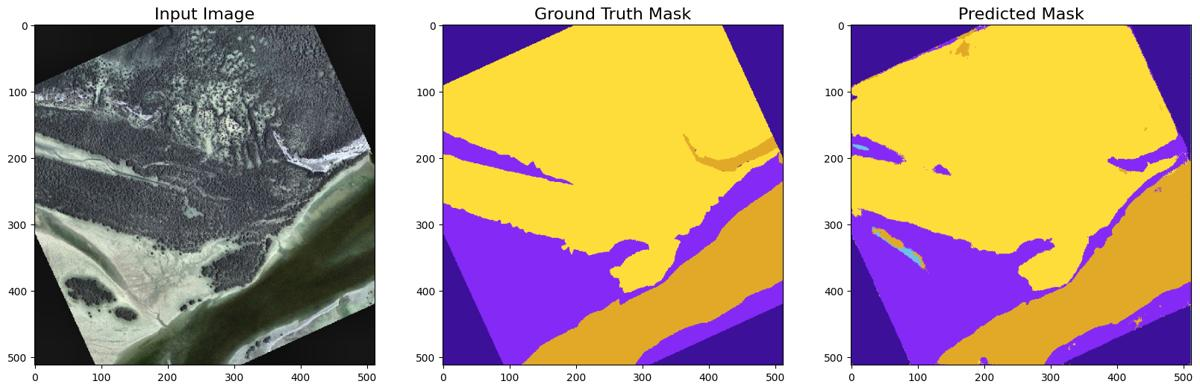


--- Statistics for Image 4 ---
  building: GT Pixels = 36745, Predicted Pixels = 36374
  land: GT Pixels = 55468, Predicted Pixels = 50311
  road: GT Pixels = 0, Predicted Pixels = 836
  vegetation: GT Pixels = 131612, Predicted Pixels = 132628
  water: GT Pixels = 38319, Predicted Pixels = 41995
  unlabeled: GT Pixels = 0, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 4:
  building: 14.02%
  land: 21.16%
  road: 0.00%
  vegetation: 50.21%
  water: 14.62%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 4:
  building: 13.88%
  land: 19.19%
  road: 0.32%
  vegetation: 50.59%
  water: 16.02%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_4.json' ✅


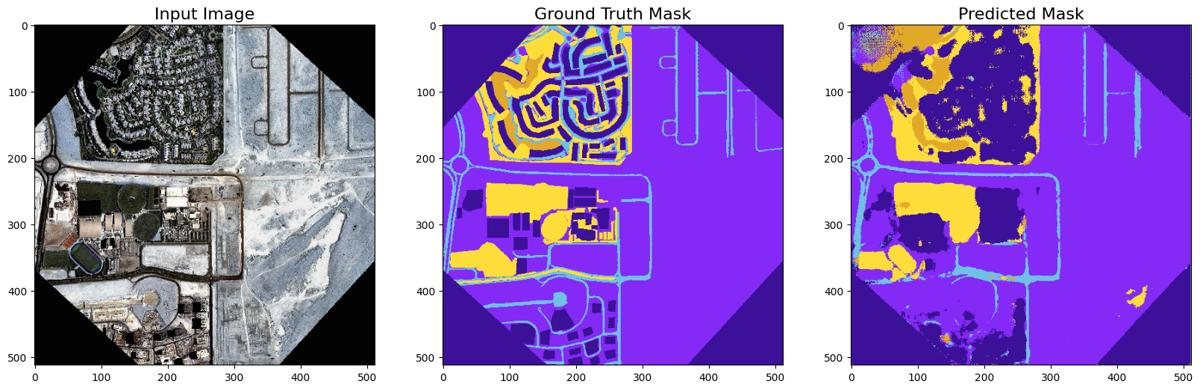


--- Statistics for Image 5 ---
  building: GT Pixels = 69421, Predicted Pixels = 82354
  land: GT Pixels = 141775, Predicted Pixels = 137890
  road: GT Pixels = 20193, Predicted Pixels = 10915
  vegetation: GT Pixels = 27650, Predicted Pixels = 22095
  water: GT Pixels = 3105, Predicted Pixels = 8478
  unlabeled: GT Pixels = 0, Predicted Pixels = 412

Area contribution (Ground Truth) for Image 5:
  building: 26.48%
  land: 54.08%
  road: 7.70%
  vegetation: 10.55%
  water: 1.18%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 5:
  building: 31.42%
  land: 52.60%
  road: 4.16%
  vegetation: 8.43%
  water: 3.23%
  unlabeled: 0.16%

Area percentages saved to './area_jsons/area_image_5.json' ✅


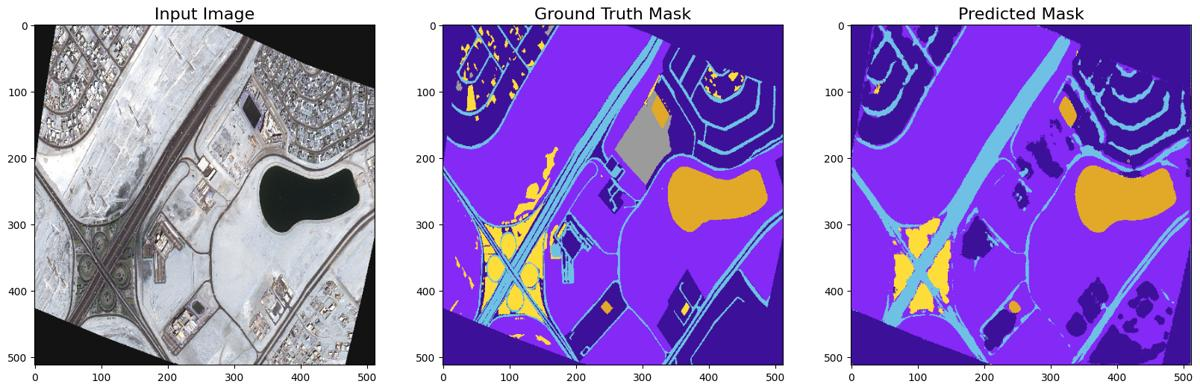


--- Statistics for Image 6 ---
  building: GT Pixels = 90925, Predicted Pixels = 74941
  land: GT Pixels = 112470, Predicted Pixels = 137775
  road: GT Pixels = 29605, Predicted Pixels = 31887
  vegetation: GT Pixels = 11873, Predicted Pixels = 5940
  water: GT Pixels = 11111, Predicted Pixels = 11601
  unlabeled: GT Pixels = 6160, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 6:
  building: 34.69%
  land: 42.90%
  road: 11.29%
  vegetation: 4.53%
  water: 4.24%
  unlabeled: 2.35%

Area contribution (Predicted) for Image 6:
  building: 28.59%
  land: 52.56%
  road: 12.16%
  vegetation: 2.27%
  water: 4.43%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_6.json' ✅


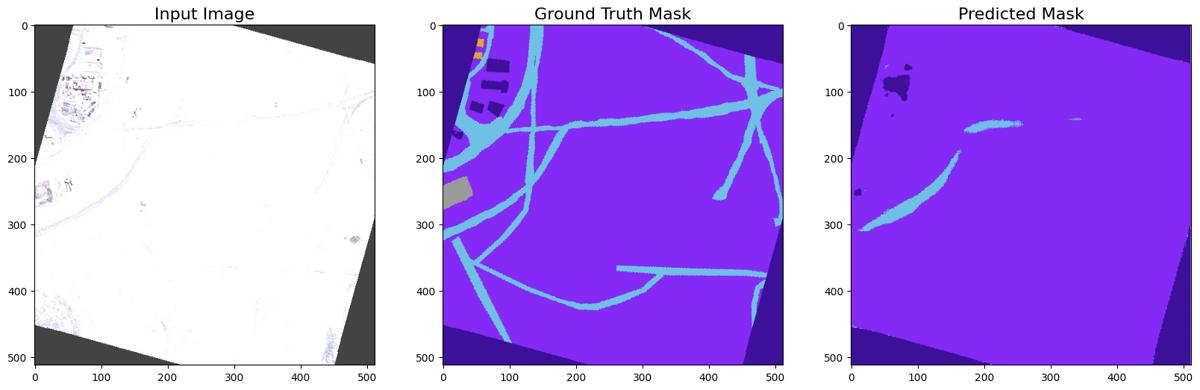


--- Statistics for Image 7 ---
  building: GT Pixels = 28553, Predicted Pixels = 26118
  land: GT Pixels = 201504, Predicted Pixels = 232206
  road: GT Pixels = 30334, Predicted Pixels = 3817
  vegetation: GT Pixels = 0, Predicted Pixels = 3
  water: GT Pixels = 235, Predicted Pixels = 0
  unlabeled: GT Pixels = 1518, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 7:
  building: 10.89%
  land: 76.87%
  road: 11.57%
  vegetation: 0.00%
  water: 0.09%
  unlabeled: 0.58%

Area contribution (Predicted) for Image 7:
  building: 9.96%
  land: 88.58%
  road: 1.46%
  vegetation: 0.00%
  water: 0.00%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_7.json' ✅


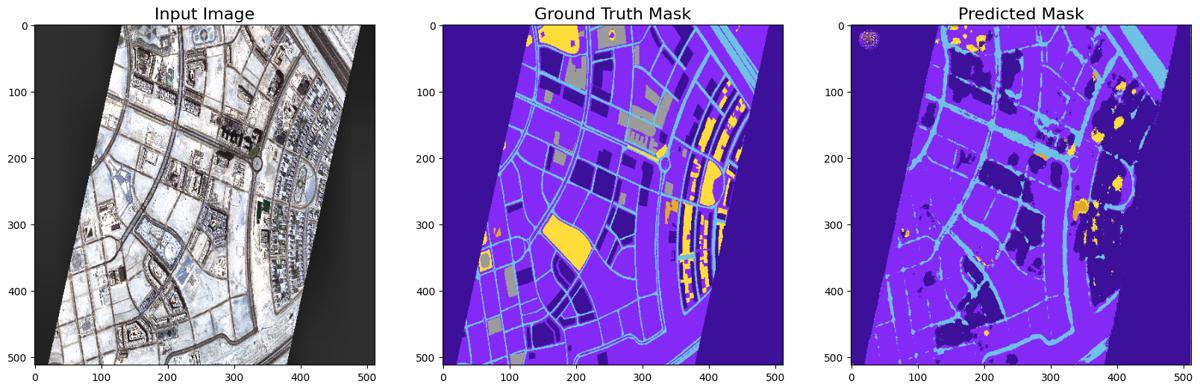


--- Statistics for Image 8 ---
  building: GT Pixels = 103750, Predicted Pixels = 118311
  land: GT Pixels = 110503, Predicted Pixels = 114877
  road: GT Pixels = 26767, Predicted Pixels = 25893
  vegetation: GT Pixels = 12049, Predicted Pixels = 2452
  water: GT Pixels = 468, Predicted Pixels = 605
  unlabeled: GT Pixels = 8607, Predicted Pixels = 6

Area contribution (Ground Truth) for Image 8:
  building: 39.58%
  land: 42.15%
  road: 10.21%
  vegetation: 4.60%
  water: 0.18%
  unlabeled: 3.28%

Area contribution (Predicted) for Image 8:
  building: 45.13%
  land: 43.82%
  road: 9.88%
  vegetation: 0.94%
  water: 0.23%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_8.json' ✅
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


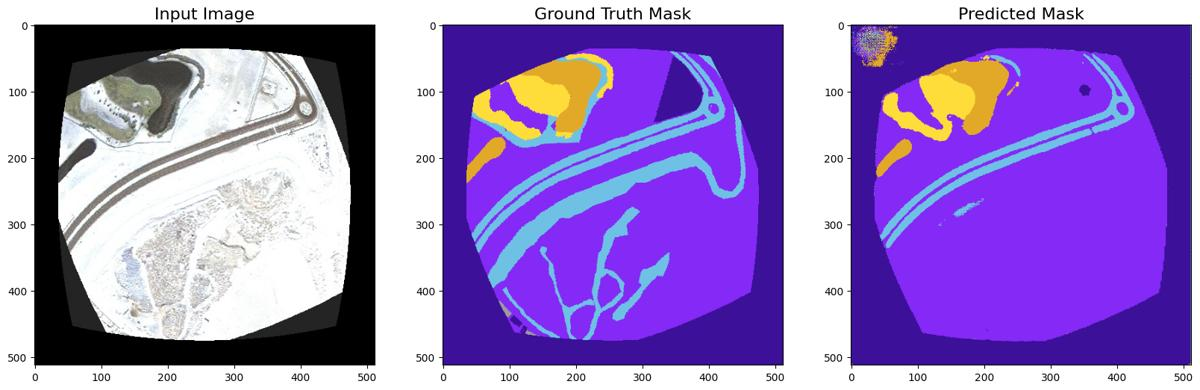


--- Statistics for Image 9 ---
  building: GT Pixels = 101710, Predicted Pixels = 93685
  land: GT Pixels = 111492, Predicted Pixels = 140981
  road: GT Pixels = 33772, Predicted Pixels = 12120
  vegetation: GT Pixels = 7594, Predicted Pixels = 6866
  water: GT Pixels = 7358, Predicted Pixels = 8156
  unlabeled: GT Pixels = 218, Predicted Pixels = 336

Area contribution (Ground Truth) for Image 9:
  building: 38.80%
  land: 42.53%
  road: 12.88%
  vegetation: 2.90%
  water: 2.81%
  unlabeled: 0.08%

Area contribution (Predicted) for Image 9:
  building: 35.74%
  land: 53.78%
  road: 4.62%
  vegetation: 2.62%
  water: 3.11%
  unlabeled: 0.13%

Area percentages saved to './area_jsons/area_image_9.json' ✅


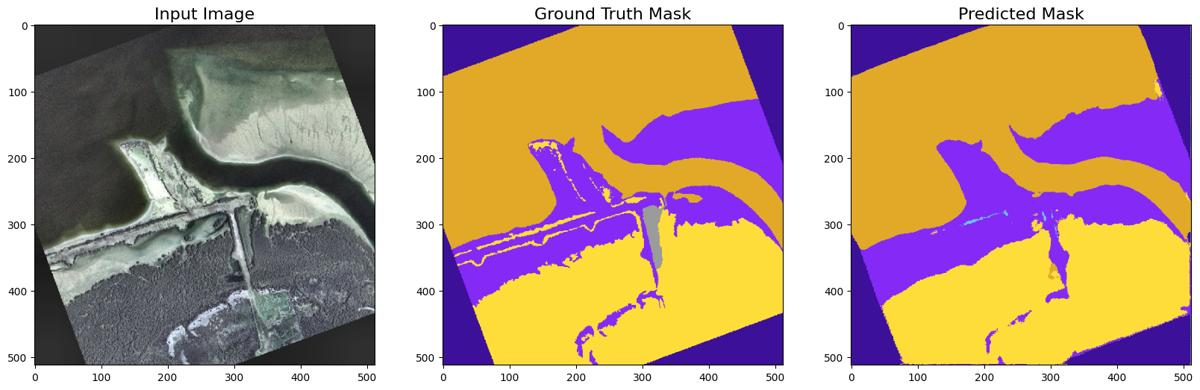


--- Statistics for Image 10 ---
  building: GT Pixels = 32764, Predicted Pixels = 31826
  land: GT Pixels = 53721, Predicted Pixels = 58495
  road: GT Pixels = 0, Predicted Pixels = 462
  vegetation: GT Pixels = 73077, Predicted Pixels = 70958
  water: GT Pixels = 100819, Predicted Pixels = 100403
  unlabeled: GT Pixels = 1763, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 10:
  building: 12.50%
  land: 20.49%
  road: 0.00%
  vegetation: 27.88%
  water: 38.46%
  unlabeled: 0.67%

Area contribution (Predicted) for Image 10:
  building: 12.14%
  land: 22.31%
  road: 0.18%
  vegetation: 27.07%
  water: 38.30%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_10.json' ✅


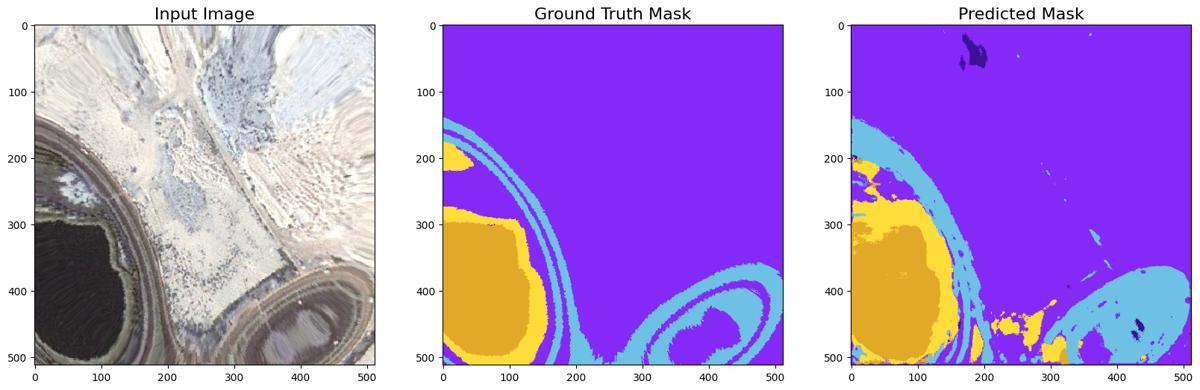


--- Statistics for Image 11 ---
  building: GT Pixels = 0, Predicted Pixels = 1462
  land: GT Pixels = 201600, Predicted Pixels = 185643
  road: GT Pixels = 27703, Predicted Pixels = 35166
  vegetation: GT Pixels = 9769, Predicted Pixels = 16334
  water: GT Pixels = 23072, Predicted Pixels = 23539
  unlabeled: GT Pixels = 0, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 11:
  building: 0.00%
  land: 76.90%
  road: 10.57%
  vegetation: 3.73%
  water: 8.80%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 11:
  building: 0.56%
  land: 70.82%
  road: 13.41%
  vegetation: 6.23%
  water: 8.98%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_11.json' ✅


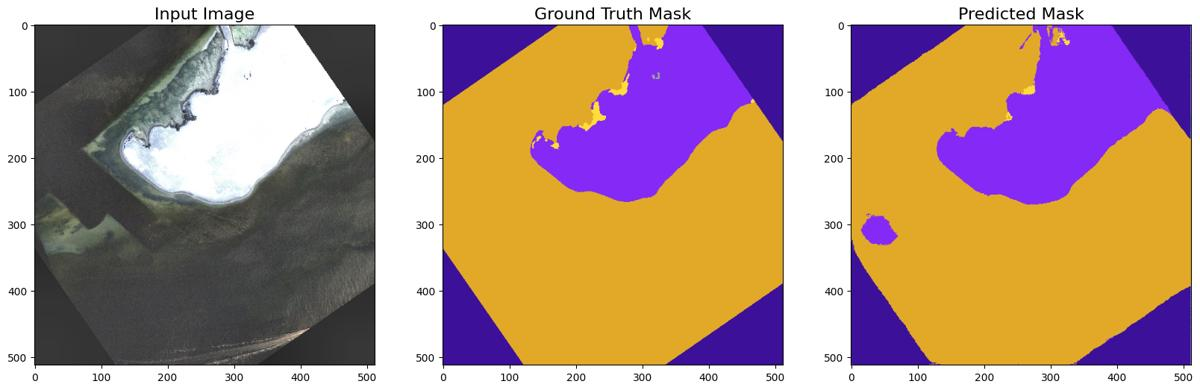


--- Statistics for Image 12 ---
  building: GT Pixels = 42912, Predicted Pixels = 42109
  land: GT Pixels = 45678, Predicted Pixels = 51636
  road: GT Pixels = 0, Predicted Pixels = 182
  vegetation: GT Pixels = 1216, Predicted Pixels = 474
  water: GT Pixels = 172274, Predicted Pixels = 167743
  unlabeled: GT Pixels = 64, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 12:
  building: 16.37%
  land: 17.42%
  road: 0.00%
  vegetation: 0.46%
  water: 65.72%
  unlabeled: 0.02%

Area contribution (Predicted) for Image 12:
  building: 16.06%
  land: 19.70%
  road: 0.07%
  vegetation: 0.18%
  water: 63.99%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_12.json' ✅


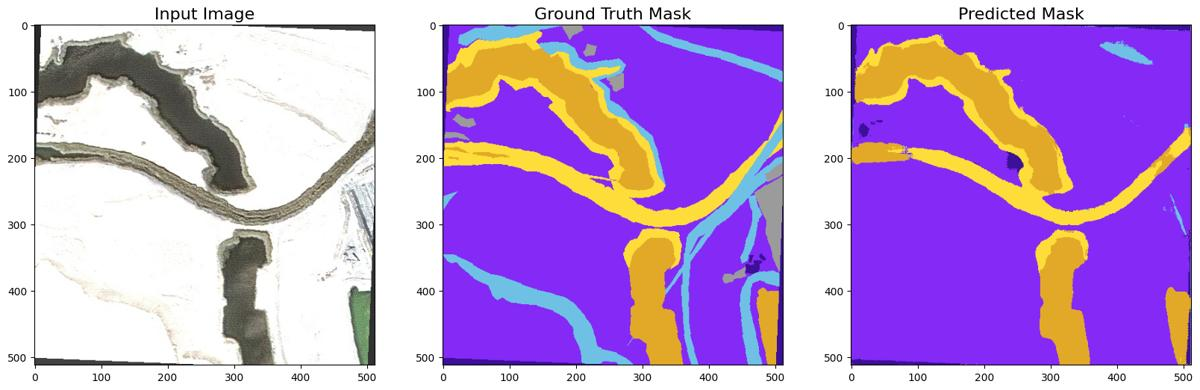


--- Statistics for Image 13 ---
  building: GT Pixels = 5600, Predicted Pixels = 4092
  land: GT Pixels = 163163, Predicted Pixels = 201140
  road: GT Pixels = 28209, Predicted Pixels = 1770
  vegetation: GT Pixels = 27032, Predicted Pixels = 19845
  water: GT Pixels = 32255, Predicted Pixels = 35297
  unlabeled: GT Pixels = 5885, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 13:
  building: 2.14%
  land: 62.24%
  road: 10.76%
  vegetation: 10.31%
  water: 12.30%
  unlabeled: 2.24%

Area contribution (Predicted) for Image 13:
  building: 1.56%
  land: 76.73%
  road: 0.68%
  vegetation: 7.57%
  water: 13.46%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_13.json' ✅


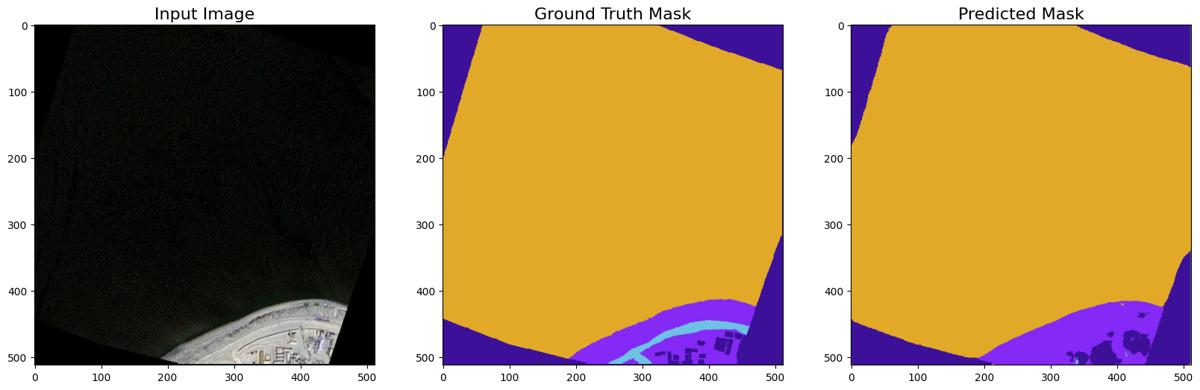


--- Statistics for Image 14 ---
  building: GT Pixels = 29204, Predicted Pixels = 27806
  land: GT Pixels = 13601, Predicted Pixels = 14796
  road: GT Pixels = 2746, Predicted Pixels = 264
  vegetation: GT Pixels = 0, Predicted Pixels = 11
  water: GT Pixels = 216593, Predicted Pixels = 219267
  unlabeled: GT Pixels = 0, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 14:
  building: 11.14%
  land: 5.19%
  road: 1.05%
  vegetation: 0.00%
  water: 82.62%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 14:
  building: 10.61%
  land: 5.64%
  road: 0.10%
  vegetation: 0.00%
  water: 83.64%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_14.json' ✅


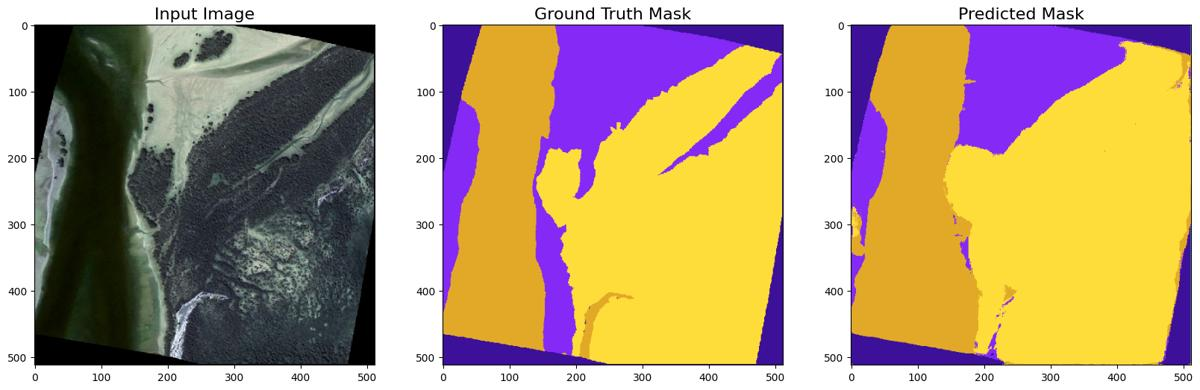


--- Statistics for Image 15 ---
  building: GT Pixels = 22102, Predicted Pixels = 21248
  land: GT Pixels = 57141, Predicted Pixels = 39412
  road: GT Pixels = 0, Predicted Pixels = 265
  vegetation: GT Pixels = 123189, Predicted Pixels = 131014
  water: GT Pixels = 59712, Predicted Pixels = 70205
  unlabeled: GT Pixels = 0, Predicted Pixels = 0

Area contribution (Ground Truth) for Image 15:
  building: 8.43%
  land: 21.80%
  road: 0.00%
  vegetation: 46.99%
  water: 22.78%
  unlabeled: 0.00%

Area contribution (Predicted) for Image 15:
  building: 8.11%
  land: 15.03%
  road: 0.10%
  vegetation: 49.98%
  water: 26.78%
  unlabeled: 0.00%

Area percentages saved to './area_jsons/area_image_15.json' ✅


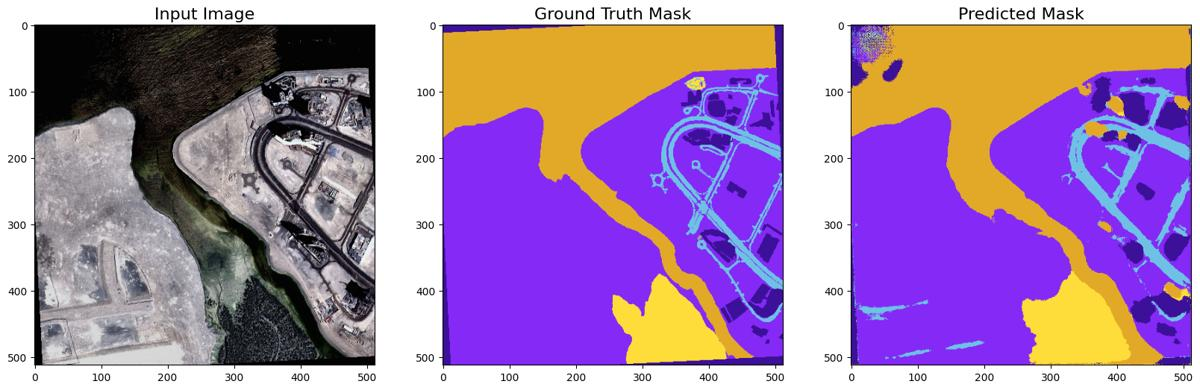


--- Statistics for Image 16 ---
  building: GT Pixels = 15182, Predicted Pixels = 14791
  land: GT Pixels = 149565, Predicted Pixels = 139888
  road: GT Pixels = 12305, Predicted Pixels = 14330
  vegetation: GT Pixels = 13861, Predicted Pixels = 15362
  water: GT Pixels = 71197, Predicted Pixels = 77398
  unlabeled: GT Pixels = 34, Predicted Pixels = 375

Area contribution (Ground Truth) for Image 16:
  building: 5.79%
  land: 57.05%
  road: 4.69%
  vegetation: 5.29%
  water: 27.16%
  unlabeled: 0.01%

Area contribution (Predicted) for Image 16:
  building: 5.64%
  land: 53.36%
  road: 5.47%
  vegetation: 5.86%
  water: 29.52%
  unlabeled: 0.14%

Area percentages saved to './area_jsons/area_image_16.json' ✅

🎯 ALL IMAGES DONE!


In [62]:
count = 0
for i in range(2):  # Loop over batches
    batch_img, batch_mask = next(testing_gen)
    pred_all = model.predict(batch_img)

    for j in range(pred_all.shape[0]):  # Loop over images in batch
        count += 1
        
        fig = plt.figure(figsize=(20, 8))

        # Input Image
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        # Ground Truth Mask
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(onehot_to_rgb(batch_mask[j], id2code))
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.grid(False)

        # Predicted Mask
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(onehot_to_rgb(pred_all[j], id2code))
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.grid(False)

        # Save Image
        plt.savefig(f'./predictions/prediction_{count}.png', facecolor='w', bbox_inches='tight', dpi=200)
        plt.show()

        # --- NEW CODE: Pixel Count & Area Percent Calculation ---

        # Convert masks to single‐channel class indices
        pred_mask = np.argmax(pred_all[j], axis=-1)
        true_mask = np.argmax(batch_mask[j], axis=-1)

        num_classes = pred_all.shape[-1]
        pred_counts = np.bincount(pred_mask.flatten(), minlength=num_classes)
        true_counts = np.bincount(true_mask.flatten(), minlength=num_classes)

        total_pixels = np.sum(true_counts)  # assuming GT and pred cover same size

        # 1) Print raw pixel counts
        print(f"\n--- Statistics for Image {count} ---")
        for cls in range(num_classes):
            cls_name = id2name.get(cls, f"Class {cls}")
            print(f"  {cls_name}: GT Pixels = {true_counts[cls]}, Predicted Pixels = {pred_counts[cls]}")

        # 2) Compute & print GT area %
        area_percent_gt = {}
        print(f"\nArea contribution (Ground Truth) for Image {count}:")
        for cls in range(num_classes):
            cls_name = id2name.get(cls, f"Class {cls}")
            pct = (true_counts[cls] / total_pixels) * 100
            area_percent_gt[cls_name] = round(pct, 2)
            print(f"  {cls_name}: {pct:.2f}%")

        # 3) Compute & print Predicted area %
        area_percent_pred = {}
        print(f"\nArea contribution (Predicted) for Image {count}:")
        for cls in range(num_classes):
            cls_name = id2name.get(cls, f"Class {cls}")
            pct = (pred_counts[cls] / total_pixels) * 100
            area_percent_pred[cls_name] = round(pct, 2)
            print(f"  {cls_name}: {pct:.2f}%")

        # 4) Save both GT & Pred area % to JSON
        out_data = {
            "ground_truth_area_percent": area_percent_gt,
            "predicted_area_percent": area_percent_pred
        }
        json_path = f'./area_jsons/area_image_{count}.json'
        with open(json_path, 'w') as f:
            json.dump(out_data, f, indent=2)

        print(f"\nArea percentages saved to '{json_path}' ✅")

print("\n🎯 ALL IMAGES DONE!")

#### Pick random image for testing

In [79]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import os

def pick_random_image(generator, model):
    """
    Pick a random image from a batch generated by the testing generator,
    along with its ground truth mask and model prediction.
    """
    batch_img, batch_mask = next(generator)
    pred_all = model.predict(batch_img)

    batch_size = batch_img.shape[0]
    rand_idx = random.randint(0, batch_size - 1)

    input_img = batch_img[rand_idx]
    true_mask = batch_mask[rand_idx]
    pred_mask_softmax = pred_all[rand_idx]

    return input_img, true_mask, pred_mask_softmax

def plot_and_save_images(input_img, true_mask, pred_mask_softmax, id2code, save_path='./predictions/random_prediction.png'):
    """
    Plot and save the input image, ground truth mask, and predicted mask.
    """
    fig = plt.figure(figsize=(20, 8))

    # Input Image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(input_img)
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    # Ground Truth Mask
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(onehot_to_rgb(true_mask, id2code))
    ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.grid(False)

    # Predicted Mask
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(onehot_to_rgb(pred_mask_softmax, id2code))
    ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.grid(False)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, facecolor='w', bbox_inches='tight', dpi=200)
    plt.show()
    print(f"\n✅ Saved visualization to '{save_path}'")

def calculate_pixel_stats(true_mask, pred_mask_softmax, id2name):
    """
    Calculate pixel counts and area percentages for ground truth and prediction.
    Returns structured dictionaries containing pixel counts and percentages.
    """
    pred_mask = np.argmax(pred_mask_softmax, axis=-1)
    true_mask = np.argmax(true_mask, axis=-1)

    num_classes = pred_mask_softmax.shape[-1]
    total_pixels = np.prod(true_mask.shape)

    pred_counts = np.bincount(pred_mask.flatten(), minlength=num_classes)
    true_counts = np.bincount(true_mask.flatten(), minlength=num_classes)

    area_gt = {}
    area_pred = {}

    print(f"\n--- Pixel Statistics for Random Image ---")
    for cls in range(num_classes):
        cls_name = id2name.get(cls, f"Class {cls}")
        print(f"  {cls_name}: GT Pixels = {true_counts[cls]}, Predicted Pixels = {pred_counts[cls]}")

    print(f"\nArea contribution (Ground Truth):")
    for cls in range(num_classes):
        cls_name = id2name.get(cls, f"Class {cls}")
        pixels = true_counts[cls]
        percent = (pixels / total_pixels) * 100
        area_gt[cls_name] = {"pixels": int(pixels), "percent": round(percent, 2)}
        print(f"  {cls_name}: {percent:.2f}%")

    print(f"\nArea contribution (Predicted):")
    for cls in range(num_classes):
        cls_name = id2name.get(cls, f"Class {cls}")
        pixels = pred_counts[cls]
        percent = (pixels / total_pixels) * 100
        area_pred[cls_name] = {"pixels": int(pixels), "percent": round(percent, 2)}
        print(f"  {cls_name}: {percent:.2f}%")

    return area_gt, area_pred

def save_area_stats(area_gt, area_pred, save_path='./area_jsons/random_image_area.json'):
    """
    Save the area percentages and pixel counts to a JSON file.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    out_data = {
        "ground_truth": area_gt,
        "prediction": area_pred
    }

    with open(save_path, 'w') as f:
        json.dump(out_data, f, indent=2)

    print(f"\n✅ Saved area percentages and pixel counts to '{save_path}'")

def run_random_test(generator, model, id2code, id2name):
    """
    Full pipeline to randomly select an image, predict, visualize, and save stats.
    Also returns the area_gt and area_pred dictionaries.
    """
    input_img, true_mask, pred_mask_softmax = pick_random_image(generator, model)
    plot_and_save_images(input_img, true_mask, pred_mask_softmax, id2code)
    area_gt, area_pred = calculate_pixel_stats(true_mask, pred_mask_softmax, id2name)
    save_area_stats(area_gt, area_pred)
    return area_gt, area_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


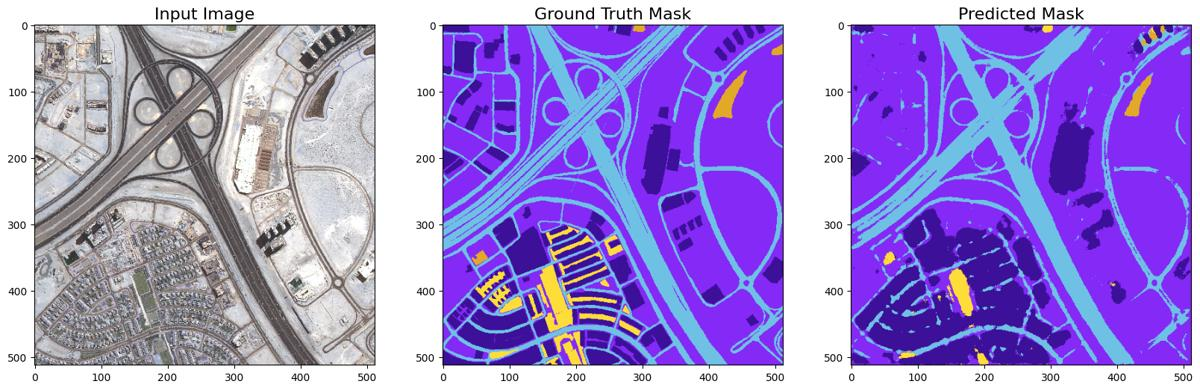


✅ Saved visualization to './predictions/random_prediction.png'

--- Pixel Statistics for Random Image ---
  building: GT Pixels = 40782, Predicted Pixels = 49027
  land: GT Pixels = 146223, Predicted Pixels = 155166
  road: GT Pixels = 64093, Predicted Pixels = 54355
  vegetation: GT Pixels = 9025, Predicted Pixels = 2454
  water: GT Pixels = 2021, Predicted Pixels = 1142
  unlabeled: GT Pixels = 0, Predicted Pixels = 0

Area contribution (Ground Truth):
  building: 15.56%
  land: 55.78%
  road: 24.45%
  vegetation: 3.44%
  water: 0.77%
  unlabeled: 0.00%

Area contribution (Predicted):
  building: 18.70%
  land: 59.19%
  road: 20.73%
  vegetation: 0.94%
  water: 0.44%
  unlabeled: 0.00%

✅ Saved area percentages and pixel counts to './area_jsons/random_image_area.json'


In [81]:
area_gt, area_pred = run_random_test(testing_gen, model, id2code, id2name)

In [80]:
def area_info_to_dataframe(area_gt, area_pred):
    """
    Converts area_gt and area_pred dictionaries into a Pandas DataFrame.
    """
    data = []
    
    for cls_name in area_gt.keys():  # assuming keys are same
        gt_info = area_gt[cls_name]
        pred_info = area_pred[cls_name]
        
        data.append({
            "Class Name": cls_name,
            "GT Pixels": gt_info['pixels'],
            "GT %": round(gt_info['percent'], 2),
            "Pred Pixels": pred_info['pixels'],
            "Pred %": round(pred_info['percent'], 2)
        })
    
    df = pd.DataFrame(data)
    return df

In [46]:
df_area = area_info_to_dataframe(area_gt, area_pred)
print("\n📋 Area Information (Pandas DataFrame):\n")
df_area


📋 Area Information (Pandas DataFrame):



Class Name  GT Pixels   GT %  Pred Pixels  Pred %
0    building      42428  16.18        41747   15.93
1        land     205397  78.35       205101   78.24
2        road       6677   2.55         4773    1.82
3  vegetation       1362   0.52         3271    1.25
4       water       5893   2.25         7243    2.76
5   unlabeled        387   0.15            9    0.00

#### Predict Image from path

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path, target_size):
    """
    Load and preprocess the image from a given path.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize if your model expects [0,1] input
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    return img_array, img

def predict_mask_on_image(img_array, model):
    """
    Predict the mask from the preprocessed image array.
    """
    pred = model.predict(img_array)
    pred_mask_softmax = pred[0]  # remove batch dimension
    return pred_mask_softmax

def plot_input_and_prediction(user_img, pred_mask_softmax, id2code, save_path='./predictions/user_prediction.png'):
    """
    Plot and save the input user image and predicted mask.
    """
    fig = plt.figure(figsize=(15, 6))

    # Input Image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(user_img)
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    # Predicted Mask
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(onehot_to_rgb(pred_mask_softmax, id2code))
    ax2.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.grid(False)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, facecolor='w', bbox_inches='tight', dpi=200)
    plt.show()
    print(f"\n✅ Saved user prediction visualization to '{save_path}'")

def calculate_predicted_area(pred_mask_softmax, id2name):
    """
    Calculate pixel counts and area percentages for prediction only.
    """
    pred_mask = np.argmax(pred_mask_softmax, axis=-1)

    num_classes = pred_mask_softmax.shape[-1]
    total_pixels = np.prod(pred_mask.shape)

    pred_counts = np.bincount(pred_mask.flatten(), minlength=num_classes)

    area_pred = {}

    print(f"\n--- Pixel Statistics for User Image Prediction ---")
    for cls in range(num_classes):
        cls_name = id2name.get(cls, f"Class {cls}")
        print(f"  {cls_name}: Predicted Pixels = {pred_counts[cls]}")

    print(f"\nArea contribution (Predicted):")
    for cls in range(num_classes):
        cls_name = id2name.get(cls, f"Class {cls}")
        pixels = pred_counts[cls]
        percent = (pixels / total_pixels) * 100
        area_pred[cls_name] = {"pixels": int(pixels), "percent": round(percent, 2)}
        print(f"  {cls_name}: {percent:.2f}%")

    return area_pred

def save_user_area_stats(area_pred, save_path='./area_jsons/user_image_area.json'):
    """
    Save the user image's predicted area info to a JSON.
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    out_data = {
        "prediction": area_pred
    }

    with open(save_path, 'w') as f:
        json.dump(out_data, f, indent=2)

    print(f"\n✅ Saved predicted area info to '{save_path}'")

def run_user_image_inference(img_path, model, id2code, id2name, target_size=(512, 512)):
    """
    Full pipeline to run prediction on a user-provided image.
    Returns predicted area dictionary.
    """
    img_array, user_img = load_and_preprocess_image(img_path, target_size)
    pred_mask_softmax = predict_mask_on_image(img_array, model)
    plot_input_and_prediction(user_img, pred_mask_softmax, id2code)
    area_pred = calculate_predicted_area(pred_mask_softmax, id2name)
    save_user_area_stats(area_pred)
    return area_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


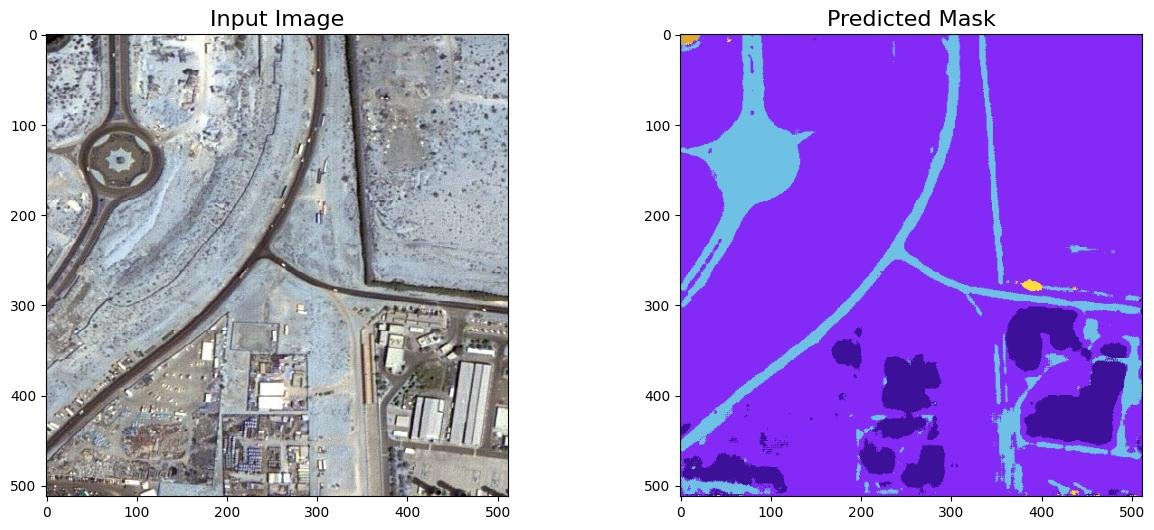


✅ Saved user prediction visualization to './predictions/user_prediction.png'

--- Pixel Statistics for User Image Prediction ---
  building: Predicted Pixels = 21753
  land: Predicted Pixels = 208594
  road: Predicted Pixels = 31287
  vegetation: Predicted Pixels = 312
  water: Predicted Pixels = 198
  unlabeled: Predicted Pixels = 0

Area contribution (Predicted):
  building: 8.30%
  land: 79.57%
  road: 11.94%
  vegetation: 0.12%
  water: 0.08%
  unlabeled: 0.00%

✅ Saved predicted area info to './area_jsons/user_image_area.json'


In [83]:
img_path = r"C:\Users\sanja\Sem-6\Applied AI\PROJECT\Semantic segmentation dataset\train_images\image_t2_009.jpg"
area_pred = run_user_image_inference(img_path, model, id2code, id2name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


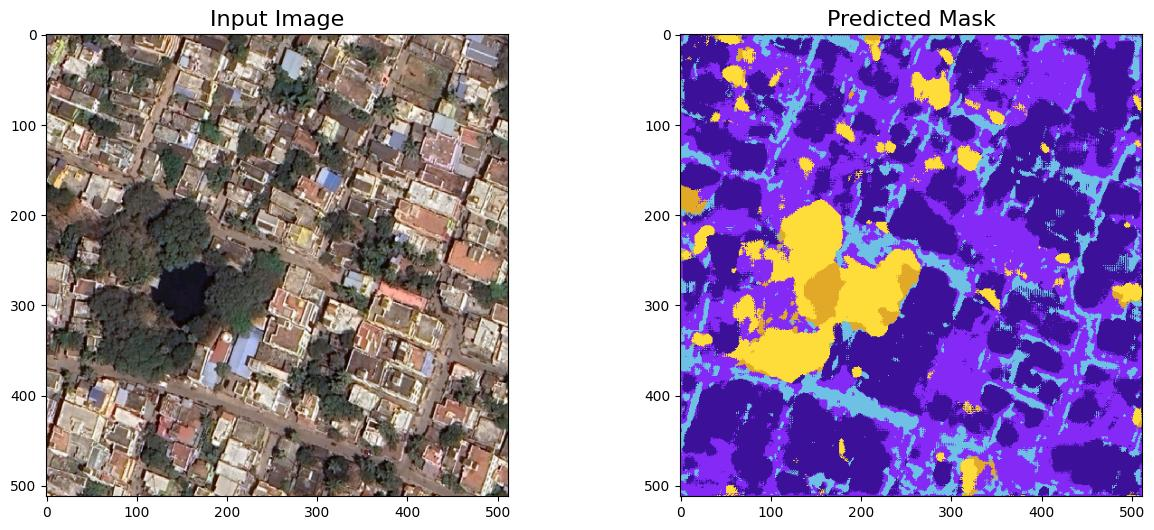


✅ Saved user prediction visualization to './predictions/user_prediction.png'

--- Pixel Statistics for User Image Prediction ---
  building: Predicted Pixels = 110595
  land: Predicted Pixels = 89143
  road: Predicted Pixels = 32077
  vegetation: Predicted Pixels = 24978
  water: Predicted Pixels = 5350
  unlabeled: Predicted Pixels = 1

Area contribution (Predicted):
  building: 42.19%
  land: 34.01%
  road: 12.24%
  vegetation: 9.53%
  water: 2.04%
  unlabeled: 0.00%

✅ Saved predicted area info to './area_jsons/user_image_area.json'


In [84]:
img_path = r"R:\Study\6th Sem\Applied AI\TEST_GOOGLE_MAP\Screenshot 2025-04-28 233043.png"
area_pred = run_user_image_inference(img_path, model, id2code, id2name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


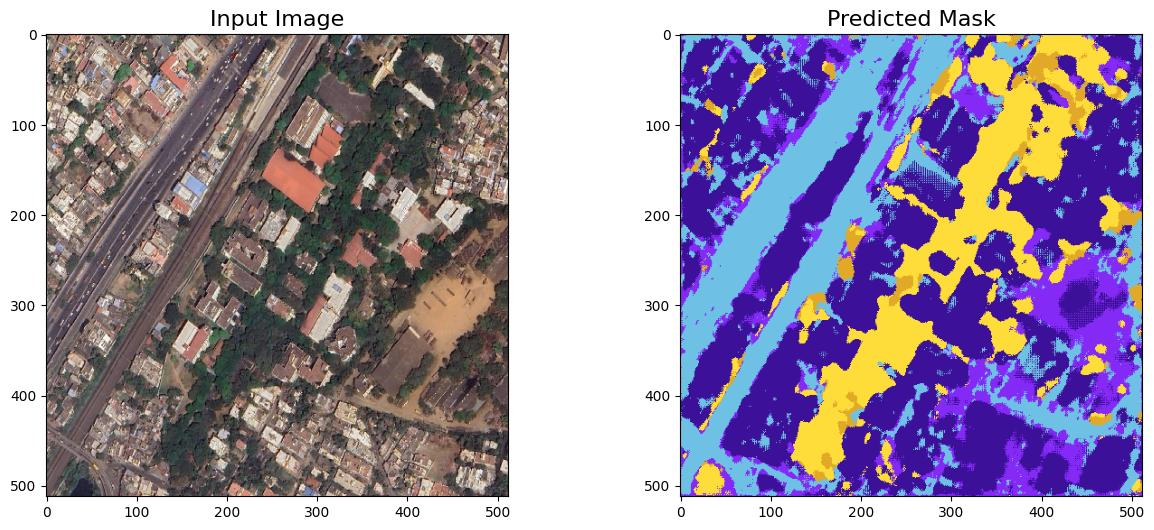


✅ Saved user prediction visualization to './predictions/user_prediction.png'

--- Pixel Statistics for User Image Prediction ---
  building: Predicted Pixels = 113734
  land: Predicted Pixels = 35503
  road: Predicted Pixels = 62915
  vegetation: Predicted Pixels = 42198
  water: Predicted Pixels = 7794
  unlabeled: Predicted Pixels = 0

Area contribution (Predicted):
  building: 43.39%
  land: 13.54%
  road: 24.00%
  vegetation: 16.10%
  water: 2.97%
  unlabeled: 0.00%

✅ Saved predicted area info to './area_jsons/user_image_area.json'


In [85]:
img_path = r"R:\Study\6th Sem\Applied AI\TEST_GOOGLE_MAP\MIT.png"
area_pred = run_user_image_inference(img_path, model, id2code, id2name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


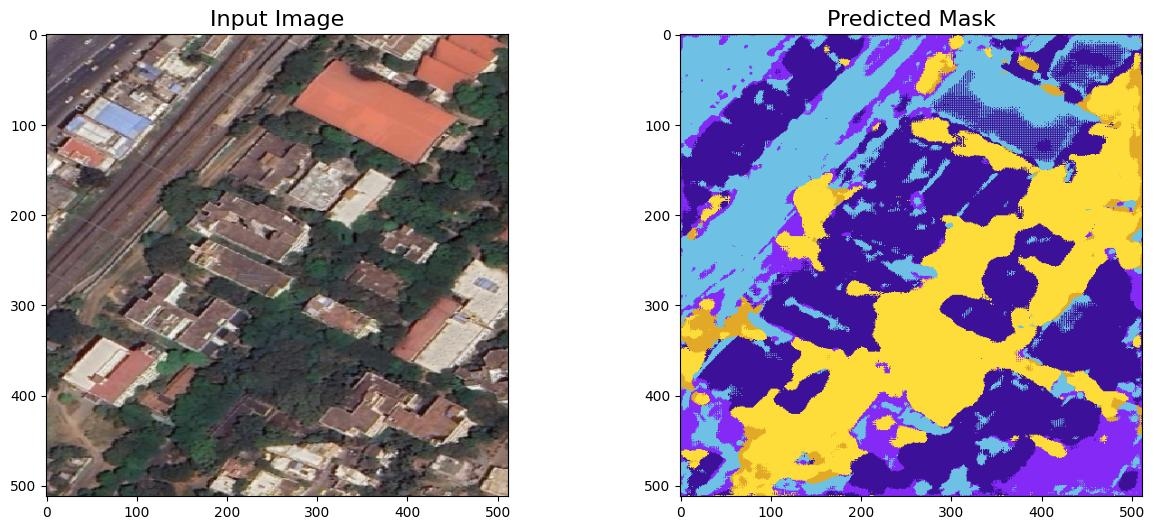


✅ Saved user prediction visualization to './predictions/user_prediction.png'

--- Pixel Statistics for User Image Prediction ---
  building: Predicted Pixels = 95505
  land: Predicted Pixels = 29537
  road: Predicted Pixels = 59766
  vegetation: Predicted Pixels = 69460
  water: Predicted Pixels = 7876
  unlabeled: Predicted Pixels = 0

Area contribution (Predicted):
  building: 36.43%
  land: 11.27%
  road: 22.80%
  vegetation: 26.50%
  water: 3.00%
  unlabeled: 0.00%

✅ Saved predicted area info to './area_jsons/user_image_area.json'


In [86]:
img_path = r"R:\Study\6th Sem\Applied AI\TEST_GOOGLE_MAP\MIT_Zoomed.png"
area_pred = run_user_image_inference(img_path, model, id2code, id2name)

## CREATING DATASET IN JSON

In [78]:

import numpy as np
import json
import os
from PIL import Image # Import Pillow for image reading

# --- Configuration ---
P2_MASK_DIR = r"Semantic segmentation dataset/All_Satellite_masks/masks/"
OUTPUT_JSON_PATH = './data_set.json' # Path for the output JSON file

def rgb_to_onehot(rgb_image, id2code):
    '''Function to one hot encode RGB mask labels
       Inputs:
           rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
           id2code - dictionary of label id to color tuple (e.g., {0: (0,0,0), 1: (255,0,0)})
       Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(id2code)
    '''
    num_classes = len(id2code)
    shape = rgb_image.shape[:2] + (num_classes,)
    encoded_image = np.zeros(shape, dtype=np.int8)
    h, w = rgb_image.shape[:2]

    # Reshape RGB image to be a list of pixels for easier comparison
    rgb_flat = rgb_image.reshape(-1, 3)

    # Iterate through class IDs and their corresponding colors
    # Find pixels matching the color and set the corresponding channel in the one-hot mask
    for class_id, color in id2code.items():
        # Create a boolean mask for pixels matching the current color
        # Need to handle potential differences in data types (e.g., mask might be uint8, color tuple is int)
        # Ensure color tuple is same dtype as image if needed, though broadcasting usually handles.
        color_mask = np.all(rgb_flat == np.array(color, dtype=rgb_image.dtype), axis=1) # True for pixels matching 'color'

        # Reshape the boolean mask back to the image dimensions
        color_mask_2d = color_mask.reshape(h, w)

        # Set the channel corresponding to the current class_id to 1
        # Ensure class_id is within the bounds of encoded_image's last dimension
        if class_id < num_classes:
             encoded_image[color_mask_2d, class_id] = 1
        # Note: Pixels with colors not in id2code will result in all channels being 0 for that pixel.
        # This is typically handled as a default 'background' or 'unlabeled' class,
        # or might indicate unannotated regions depending on your data.

    return encoded_image

def onehot_to_rgb(onehot, id2code):
    '''Function to decode encoded mask labels
        Inputs:
            onehot - one hot encoded image matrix (height x width x num_classes)
            id2code - dictionary of label id to color tuple
        Output: Decoded RGB image (height x width x 3)
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,), dtype=np.uint8) # Specify dtype
    for k in id2code.keys():
        output[single_layer==k] = id2code[k]
    return output # Return uint8 output


# --- Main Processing Function ---

def process_masks_in_directory(mask_dir, id2name, id2code, output_json_path):
    """
    Reads RGB mask images from a directory, converts them to one-hot and index masks,
    calculates ground truth pixel area percentage for each image,
    and saves results to a JSON file.

    Args:
        mask_dir: Path to the directory containing RGB mask images.
        id2name: Dictionary mapping class integer IDs to names.
        id2code: Dictionary mapping class integer IDs to RGB colors.
        output_json_path: Path to save the output JSON file.
    """
    all_images_gt_stats = {}
    # Use the number of classes from the mappings
    num_classes_name = len(id2name)
    num_classes_code = len(id2code)

    if num_classes_name != num_classes_code:
         print("Error: id2name and id2code dictionaries have a different number of classes!")
         print("Please ensure they cover the same set of class IDs.")
         return {} # Exit if mappings are inconsistent

    num_classes = num_classes_name # Use this as the definitive number

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    print(f"Starting ground truth stats collection from directory: {mask_dir}")

    # List all files in the mask directory
    all_files = os.listdir(mask_dir)

    # Filter for common image file extensions (you might need to adjust this)
    image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]

    if not image_files:
        print(f"No image files found in {mask_dir}. Nothing to process.")
        # Save an empty or minimal JSON if no files are found
        with open(output_json_path, 'w') as f:
            json.dump({"message": f"No image files found in {mask_dir}"}, f, indent=2)
        print(f"\n✅ Created placeholder '{output_json_path}' as no images were found.")
        return {}


    print(f"Found {len(image_files)} image files.")

    for i, filename in enumerate(image_files):
        full_filepath = os.path.join(mask_dir, filename)

        try:
            # Read the image using Pillow
            img = Image.open(full_filepath)

            # Ensure image is in RGB format if it's not already (e.g., Palette based PNG)
            # This is important before converting to numpy array for rgb_to_onehot
            if img.mode != 'RGB':
                 img = img.convert('RGB')

            # Convert image data to a NumPy array
            rgb_mask_array = np.array(img)

            # --- Convert RGB mask to one-hot and then to index mask ---
            # Use the provided rgb_to_onehot function
            onehot_mask = rgb_to_onehot(rgb_mask_array, id2code)

            # Convert one-hot mask to single-channel index mask for bincount
            true_mask_index = np.argmax(onehot_mask, axis=-1)

            # Ensure the index mask data type is suitable for bincount (integers)
            true_mask_index = true_mask_index.astype(np.int32)

            # Check if any pixels were assigned a class (i.e., argmax didn't return all zeros)
            # This can happen if some colors in the mask are NOT in id2code
            # Pixels that did not match any color in id2code will have all channels as 0 in the one-hot mask.
            # np.argmax(..., axis=-1) on a [0,0,0] vector results in 0.
            # So, pixels with unmapped colors will default to class 0 (background) if 0 is mapped.
            # If 0 is NOT mapped, or you need strict checking, you might add checks here.
            # For now, we rely on np.argmax mapping non-matching pixels to index 0.


            # --- Calculate pixel counts and area percentages ---
            # bincount needs max value + 1 or minlength. Using minlength based on num_classes is safer.
            true_counts = np.bincount(true_mask_index.flatten(), minlength=num_classes)
            total_pixels = np.prod(true_mask_index.shape)

            image_stats = {}
            if total_pixels == 0:
                 print(f"Warning: Mask {filename} has zero pixels after processing. Stats will be 0.")
                 image_stats = {id2name.get(cls, f"Class {cls}"): 0.0 for cls in range(num_classes)}
            else:
                # Sort id2name keys to ensure consistent class order in JSON
                for cls in sorted(id2name.keys()):
                    cls_name = id2name.get(cls, f"Class {cls}")
                    # Check if cls is within the bounds of true_counts array
                    if cls < len(true_counts):
                         pct = (true_counts[cls] / total_pixels) * 100
                         image_stats[cls_name] = round(pct, 2)
                    else:
                         # This case should ideally not be reached if minlength is used correctly,
                         # but acts as a safeguard.
                         image_stats[cls_name] = 0.0


            # Store stats for this image using its filename as the key
            all_images_gt_stats[filename] = image_stats

            # Progress indicator
            print(f"Processed {i + 1}/{len(image_files)}: {filename}", end='\r')

        except FileNotFoundError:
            print(f"\nError: File not found: {full_filepath}. Skipping.")
            continue
        except Exception as e:
            print(f"\nError processing {filename}: {e}. Skipping.")
            # Print traceback for debugging unexpected errors
            # import traceback
            # traceback.print_exc()
            continue

    print("\nFinished processing all images.")

    # Save the collected ground truth stats to a single JSON file
    try:
        with open(output_json_path, 'w') as f:
            json.dump(all_images_gt_stats, f, indent=2)
        print(f"\n🎯 Successfully saved ground truth area percentages for {len(all_images_gt_stats)} images to '{output_json_path}'")
    except Exception as e:
        print(f"\n❌ Error saving data to '{output_json_path}': {e}")

    print("\nProcess complete.")
    return all_images_gt_stats # Optionally return the data

process_masks_in_directory(P2_MASK_DIR, id2name, id2code, OUTPUT_JSON_PATH)

Starting ground truth stats collection from directory: Semantic segmentation dataset/All_Satellite_masks/masks/
Found 72 image files.
Processed 72/72: image_t8_009.png
Finished processing all images.

🎯 Successfully saved ground truth area percentages for 72 images to './data_set.json'

Process complete.


{'image_t1_001.png': {'building': 0.54,
  'land': 75.7,
  'road': 14.24,
  'vegetation': 0.85,
  'water': 7.12,
  'unlabeled': 1.54},
 'image_t1_002.png': {'building': 0.0,
  'land': 70.81,
  'road': 8.31,
  'vegetation': 0.0,
  'water': 20.44,
  'unlabeled': 0.44},
 'image_t1_003.png': {'building': 3.03,
  'land': 64.12,
  'road': 14.04,
  'vegetation': 6.97,
  'water': 11.49,
  'unlabeled': 0.35},
 'image_t1_004.png': {'building': 0.78,
  'land': 83.72,
  'road': 12.68,
  'vegetation': 0.0,
  'water': 0.16,
  'unlabeled': 2.66},
 'image_t1_005.png': {'building': 1.22,
  'land': 49.65,
  'road': 10.25,
  'vegetation': 0.0,
  'water': 38.86,
  'unlabeled': 0.02},
 'image_t1_006.png': {'building': 7.62,
  'land': 50.07,
  'road': 16.62,
  'vegetation': 5.26,
  'water': 20.27,
  'unlabeled': 0.15},
 'image_t1_007.png': {'building': 0.81,
  'land': 71.66,
  'road': 10.35,
  'vegetation': 4.7,
  'water': 12.45,
  'unlabeled': 0.03},
 'image_t1_008.png': {'building': 13.82,
  'land': 53.84,

## GAN

In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

def build_generator(input_shape_mask=(512,512,6), input_shape_img=(512,512,3)):
    # Inputs: predicted mask and original image
    mask_input = Input(shape=input_shape_mask, name='pred_mask')
    img_input  = Input(shape=input_shape_img, name='orig_image')
    x = Concatenate(axis=-1)([mask_input, img_input])  # shape (512,512,9)
    
    # Downsampling path
    d1 = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    d1 = LeakyReLU(alpha=0.2)(d1)  # shape (256,256,64)

    d2 = Conv2D(128, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)  # (128,128,128)

    d3 = Conv2D(256, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)  # (64,64,256)

    d4 = Conv2D(512, 4, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)  # (32,32,512)

    d5 = Conv2D(512, 4, strides=2, padding='same')(d4)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU(alpha=0.2)(d5)  # (16,16,512) - bottleneck

    # Upsampling path (with skip connections)
    u1 = Conv2DTranspose(512, 4, strides=2, padding='same')(d5)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Concatenate(axis=-1)([u1, d4])  # (32,32,1024)

    u2 = Conv2DTranspose(256, 4, strides=2, padding='same')(u1)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Concatenate(axis=-1)([u2, d3])  # (64,64,512)

    u3 = Conv2DTranspose(128, 4, strides=2, padding='same')(u2)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Concatenate(axis=-1)([u3, d2])  # (128,128,256)

    u4 = Conv2DTranspose(64, 4, strides=2, padding='same')(u3)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Concatenate(axis=-1)([u4, d1])  # (256,256,128)

    u5 = Conv2DTranspose(64, 4, strides=2, padding='same')(u4)
    u5 = BatchNormalization()(u5)
    u5 = Activation('relu')(u5)         # (512,512,64)

    # Final output layer: 6 classes with softmax
    output_mask = Conv2D(6, kernel_size=1, activation='softmax')(u5)  # (512,512,6)
    
    return Model(inputs=[mask_input, img_input], outputs=output_mask, name='Generator')

# Instantiate the generator
generator = build_generator()
generator.summary()

C:\Users\sanja\anaconda3\envs\tf\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pred_mask (InputLayer)        │ (None, 512, 512, 6)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ orig_image (InputLayer)       │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 512, 512, 9)       │               0 │ pred_mask[0][0],           │
│                               │                           │                 │ orig_image[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_212 (Conv2D)           │ (None, 256, 256, 64)      │           9,280 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 256, 256, 64)      │               0 │ conv2d_212[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_213 (Conv2D)           │ (None, 128, 128, 128)     │         131,200 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_211       │ (None, 128, 128, 128)     │             512 │ conv2d_213[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_211[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_214 (Conv2D)           │ (None, 64, 64, 256)       │         524,544 │ leaky_re_lu_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_212       │ (None, 64, 64, 256)       │           1,024 │ conv2d_214[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 64, 64, 256)       │               0 │ batch_normalization_212[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_215 (Conv2D)           │ (None, 32, 32, 512)       │       2,097,664 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_213       │ (None, 32, 32, 512)       │           2,048 │ conv2d_215[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 32, 32, 512)       │               0 │ batch_normalization_213[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_216 (Conv2D)           │ (None, 16, 16, 512)       │       4,194,816 │ leaky_re_lu_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 16,799,046 (64.08 MB)

 Trainable params: 16,794,182 (64.06 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [88]:
def build_discriminator(input_shape_mask=(512,512,6), input_shape_img=(512,512,3)):
    mask_input = Input(shape=input_shape_mask, name='seg_mask')
    img_input  = Input(shape=input_shape_img, name='orig_image')
    x = Concatenate(axis=-1)([img_input, mask_input])  # (512,512,9)
    
    # Downscaling conv layers
    d1 = Conv2D(64, 4, strides=2, padding='same')(x)
    d1 = LeakyReLU(alpha=0.2)(d1)  # (256,256,64)
    
    d2 = Conv2D(128, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)  # (128,128,128)
    
    d3 = Conv2D(256, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(alpha=0.2)(d3)  # (64,64,256)
    
    d4 = Conv2D(512, 4, strides=1, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)  # (64,64,512)
    
    # Final output: 1-channel patch output
    patch_out = Conv2D(1, 4, strides=1, padding='same')(d4)  # (64,64,1) patch logits
    return Model(inputs=[mask_input, img_input], outputs=patch_out, name='Discriminator')

# Instantiate the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ orig_image (InputLayer)       │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ seg_mask (InputLayer)         │ (None, 512, 512, 6)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_9 (Concatenate)   │ (None, 512, 512, 9)       │               0 │ orig_image[0][0],          │
│                               │                           │                 │ seg_mask[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_218 (Conv2D)           │ (None, 256, 256, 64)      │           9,280 │ concatenate_9[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU)     │ (None, 256, 256, 64)      │               0 │ conv2d_218[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_219 (Conv2D)           │ (None, 128, 128, 128)     │         131,200 │ leaky_re_lu_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_220       │ (None, 128, 128, 128)     │             512 │ conv2d_219[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU)     │ (None, 128, 128, 128)     │               0 │ batch_normalization_220[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_220 (Conv2D)           │ (None, 64, 64, 256)       │         524,544 │ leaky_re_lu_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_221       │ (None, 64, 64, 256)       │           1,024 │ conv2d_220[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU)     │ (None, 64, 64, 256)       │               0 │ batch_normalization_221[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_221 (Conv2D)           │ (None, 64, 64, 512)       │       2,097,664 │ leaky_re_lu_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_222       │ (None, 64, 64, 512)       │           2,048 │ conv2d_221[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU)     │ (None, 64, 64, 512)       │               0 │ batch_normalization_222[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_222 (Conv2D)           │ (None, 64, 64, 1)         │           8,193 │ leaky_re_lu_8[0][0]        │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 2,774,465 (10.58 MB)

 Trainable params: 2,772,673 (10.58 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
import tensorflow as tf

# Loss functions and optimizers
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
ce_loss  = tf.keras.losses.CategoricalCrossentropy()  # segmentation loss
lambda_seg = 10.0  # weight for segmentation loss
g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Example training loop
for epoch in range(num_epochs):
    for (real_img, pred_mask, true_mask) in dataset:  # ground-truth image, predicted mask, true mask
        # -------------------------
        # Update Discriminator
        # -------------------------
        with tf.GradientTape() as d_tape:
            # Generate fake mask
            fake_mask = generator([pred_mask, real_img], training=True)
            
            # Discriminator outputs for real and fake
            real_output = discriminator([true_mask, real_img], training=True)
            fake_output = discriminator([fake_mask, real_img], training=True)
            
            # Discriminator loss: real->1, fake->0
            d_loss_real = bce_loss(tf.ones_like(real_output), real_output)
            d_loss_fake = bce_loss(tf.zeros_like(fake_output), fake_output)
            d_loss = (d_loss_real + d_loss_fake) * 0.5
        
        # Compute and apply gradients to D
        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
        
        # -------------------------
        # Update Generator
        # -------------------------
        with tf.GradientTape() as g_tape:
            fake_mask = generator([pred_mask, real_img], training=True)
            fake_output = discriminator([fake_mask, real_img], training=False)
            
            # Generator adversarial loss (wants D(fake) ~ 1)
            adv_loss = bce_loss(tf.ones_like(fake_output), fake_output)
            # Segmentation loss: compare fake_mask with true_mask
            seg_loss = ce_loss(true_mask, fake_mask)  # or tf.keras.losses.Dice()
            
            # Total generator loss
            g_loss = adv_loss + lambda_seg * seg_loss
        
        # Compute and apply gradients to G
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
        
        # (Optional) log losses, etc.